## Packages

In [1]:
import numpy as np                                # scientific computing toolkit
import pandas as pd                               # data analysis toolkit
import scanpy as sc                               # scanpy is referred to with sc.***
import matplotlib.pyplot as plt                   # Matplotlib is referred to with plt.***
from scipy import stats                           # for linear regressions
import seaborn as sns                             # for easy heatmaps
import scirpy as ir                               # TCR analysis
import scvelo as scv

sc.settings.verbosity = 3                         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()                         # check if all needed versions are installed and up to date (old: print_Versions(), changed in new version of scanpy)
results_directory = './Analysis_output/'
results_file = results_directory + '/results_file/write/results.h5ad'             # the file that will store the analysis results

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)

batchglm version v0.7.4
diffpy version refs/pull/219/head


Seaborn settings

In [3]:
sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

Matplotlib

In [4]:
import matplotlib as mpl
plt.style.use('default')
mpl.rcParams['axes.linewidth'] = 0.5 #set the value globally

## Directory variables

In [5]:
import glob
import os
from pathlib import Path

sample_directory = './GEX_VDJ/'
analysis_info = './analysis_info/'
adata_directory = './'

In [6]:
plt.rcParams['figure.figsize']=(6,6) #rescale figures
sc.settings.set_figure_params(dpi=100, dpi_save=600, color_map='viridis', vector_friendly=True, format='eps')
### you can set a default figure directory here for saving output
sc.settings.figdir = "./analysis_output/figures_scanpy/"
## Figure directory for matplotlib figures/axes
save_figure_sc = "./analysis_output/figures_scanpy/"
#Use
#plt.savefig(save_figure + 'image.pdf')
save_figure_ir = "./analysis_output/figures_scirpy/"
save_nx = "./analysis_output/tcr_clusters/"
#csv directory
read_csv = './analysis_output/saved_tables/'
save_csv = r'./analysis_output/saved_tables/'

TCRdist3 and plotting

In [7]:
#TCRdist and plotting
import networkx as nx
from tcrdist.html_colors import get_html_colors
import community.community_louvain as community_louvain

from tcrdist.repertoire import TCRrep
import dill
import pwseqdist as pw
import igraph as ig
from pylab import *

In [8]:
import pygraphviz

## Load Data

In [9]:
adata = sc.read(adata_directory + 'adata_stim_unstim_figures.h5ad')

In [10]:
adata

AnnData object with n_obs × n_vars = 52804 × 3011
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'experiment', 'gro

In [573]:
adata.obs.isolation='multimer'
adata.obs.isolation[adata.obs.multimer=='not_stained']='cd44'

### Reduce TCR dist

In [54]:
def tr_calc(df, save=True, filename=None,cdr3_a_aa_value=3,cdr3_b_aa_value=3,pmhc_a_aa_value=1,pmhc_b_aa_value=1):
    
    from tcrdist.repertoire import TCRrep
    import dill
    import pwseqdist as pw
    
    global tr
    tr = TCRrep(cell_df = df, 
                organism = 'mouse', 
                chains = ['alpha','beta'], 
                db_file = 'alphabeta_gammadelta_db.tsv',
                deduplicate = True,
                cpus=12,
                compute_distances = False)

    metrics_a = {
        "cdr3_a_aa" : pw.metrics.nb_vector_tcrdist,
        "pmhc_a_aa" : pw.metrics.nb_vector_tcrdist,
        "cdr2_a_aa" : pw.metrics.nb_vector_tcrdist,
        "cdr1_a_aa" : pw.metrics.nb_vector_tcrdist}

    metrics_b = {
        "cdr3_b_aa" : pw.metrics.nb_vector_tcrdist,
        "pmhc_b_aa" : pw.metrics.nb_vector_tcrdist,
        "cdr2_b_aa" : pw.metrics.nb_vector_tcrdist,
        "cdr1_b_aa" : pw.metrics.nb_vector_tcrdist }

    weights_a= { 
        "cdr3_a_aa" : cdr3_a_aa_value,
        "pmhc_a_aa" : pmhc_a_aa_value,
        "cdr2_a_aa" : 1,
        "cdr1_a_aa" : 1}

    weights_b = { 
        "cdr3_b_aa" : cdr3_b_aa_value,
        "pmhc_b_aa" : pmhc_b_aa_value,
        "cdr2_b_aa" : 1,
        "cdr1_b_aa" : 1}

    kargs_a = {  
        'cdr3_a_aa' : 
            {'use_numba': True, 
            'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 
            'dist_weight': 1, 
            'gap_penalty':4, 
            'ntrim':3, 
            'ctrim':2, 
            'fixed_gappos': False},
        'pmhc_a_aa' : {
            'use_numba': True,
            'distance_matrix': pw.matrices.tcr_nb_distance_matrix,
            'dist_weight':1,
            'gap_penalty':4,
            'ntrim':0,
            'ctrim':0,
            'fixed_gappos':True},
        'cdr2_a_aa' : {
            'use_numba': True,
            'distance_matrix': pw.matrices.tcr_nb_distance_matrix,
            'dist_weight': 1,
            'gap_penalty':4,
            'ntrim':0,
            'ctrim':0,
            'fixed_gappos':True},
        'cdr1_a_aa' : {
            'use_numba': True,
            'distance_matrix': pw.matrices.tcr_nb_distance_matrix,
            'dist_weight':1,
            'gap_penalty':4,
            'ntrim':0,
            'ctrim':0,
            'fixed_gappos':True}
        }
    kargs_b= {  
        'cdr3_b_aa' : 
            {'use_numba': True, 
            'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 
            'dist_weight': 1, 
            'gap_penalty':4, 
            'ntrim':3, 
            'ctrim':2, 
            'fixed_gappos': False},
        'pmhc_b_aa' : {
            'use_numba': True,
            'distance_matrix': pw.matrices.tcr_nb_distance_matrix,
            'dist_weight': 1,
            'gap_penalty':4,
            'ntrim':0,
            'ctrim':0,
            'fixed_gappos':True},
        'cdr2_b_aa' : {
            'use_numba': True,
            'distance_matrix': pw.matrices.tcr_nb_distance_matrix,
            'dist_weight':1,
            'gap_penalty':4,
            'ntrim':0,
            'ctrim':0,
            'fixed_gappos':True},
        'cdr1_b_aa' : {
            'use_numba': True,
            'distance_matrix': pw.matrices.tcr_nb_distance_matrix,
            'dist_weight':1,
            'gap_penalty':4,
            'ntrim':0,
            'ctrim':0,
            'fixed_gappos':True}
        }   

    tr.metrics_a = metrics_a
    tr.metrics_b = metrics_b

    tr.weights_a = weights_a
    tr.weights_b = weights_b

    tr.kargs_a = kargs_a 
    tr.kargs_b = kargs_b

    tr.compute_distances()
    
    if save==True:
        outfile = r'./analysis_output/tcrdist/selected/' + 'clone_df_' + filename + '.csv'
        tr.clone_df.to_csv(outfile, sep =",", index =False)
        

    #dill.dump(tr, open("./analysis_output/tcrdist/" + save, mode='wb'))

In [177]:
def create_df_network(tr=None, edge = 120, filename='df_net', save=True):
    from tcrdist.public import _neighbors_fixed_radius
    # <edge_threshold> is used to define maximum distance to for a network edge
    edge_threshold = edge
    # <tr.pw_alpha_beta> is paired chain TCRdist
    tr.pw_alpha_beta = tr.pw_beta + tr.pw_alpha
    # <network> initialize a list to populate with edges between TCRs.
    network = list()
    for i,n in enumerate(_neighbors_fixed_radius(tr.pw_alpha_beta, edge_threshold)):
        for j in n:
            if i != j:
                network.append((
                    i, # 'node_1' -row index
                    j, # 'node_2' -column index
                    (tr.pw_alpha_beta)[i,j], # 'dist'-gets the distance between TCR(i,j_

                    tr.clone_df['v_b_gene'].iloc[i], # 'v_b_gene_1' -vbeta gene of clone i
                    tr.clone_df['v_b_gene'].iloc[j], # 'v_b_gene_2' -v beta gene of clone j
                    tr.clone_df['cdr3_b_aa'].iloc[i], # 'cdr3_b_aa_1' -cdr3 beta of clone i
                    tr.clone_df['cdr3_b_aa'].iloc[j], #'cdr3_b_aa_2' -cdr3 beta of clone j
                    tr.clone_df['subject'].iloc[i], # 'subject_1' -subject of clone i
                    tr.clone_df['subject'].iloc[j], # 'subject_2' -subject of clone j
                    tr.clone_df['epitope'].iloc[i], # 'epitope_1' -epitope associated with clone i
                    tr.clone_df['epitope'].iloc[j], #'epitope_2' -epitope associated with clone j
                    tr.clone_df['v_a_gene'].iloc[i], 
                    tr.clone_df['v_a_gene'].iloc[j], 
                    tr.clone_df['cdr3_a_aa'].iloc[i], 
                    tr.clone_df['cdr3_a_aa'].iloc[j],
                    tr.clone_df['clone_id'].iloc[i], 
                    tr.clone_df['clone_id'].iloc[j],
                    tr.clone_df['count'].iloc[i], 
                    tr.clone_df['count'].iloc[j],
                    tr.clone_df['count_by_mouse'].iloc[i], 
                    tr.clone_df['count_by_mouse'].iloc[j],
                    tr.clone_df['isolation'].iloc[i], 
                    tr.clone_df['isolation'].iloc[j],
                    #tr.clone_df['avidity_cat'].iloc[i], 
                    #tr.clone_df['avidity_cat'].iloc[j],
                    #tr.clone_df['tcr_cat'].iloc[i], 
                    #tr.clone_df['tcr_cat'].iloc[j],
                    
                    

                    len(n)-1 # 'K_neighbors' -number of neighbors
                    ))

    cols = ['node_1', 'node_2', 'dist', 'v_b_gene_1', 'v_b_gene_2',
            'cdr3_b_aa_1','cdr3_b_aa_2', 'subject_1','subject_2',
            'epitope_1','epitope_2', 'v_a_gene_1', 'v_a_gene_2','cdr3_a_aa_1','cdr3_a_aa_2', 'clone_id_1', 'clone_id_2',
            'count_1','count_2', 'count_by_mouse_1','count_by_mouse_2','isolation_1','isolation_2','K_neighbors']
            
            #'clonotype_origin_1','clonotype_origin_2','avidity_cat_1','avidity_cat_2','tcr_cat_1','tcr_cat_2',
            
    # Store the <network> edge list as a DataFrame.
    
    global df_net
    df_net = pd.DataFrame(network, columns =cols)
    if save==True:
        # Option to write the edge list to a file for use in Gephi, Cytoscape, R, etc.
        outfile = r'./analysis_output/tcrdist/selected/'+filename + '.csv'
        df_net.to_csv(outfile, sep =",", index =False)

### Load TCR library data

In [99]:
df_clonotypes_all = adata.obs.groupby('clone_id').agg(
    subject = ('mouse','first'),
    v_a_gene = ('IR_VJ_1_v_call','first'),
    j_a_gene = ('IR_VJ_1_j_call','first'),
    cdr3_a_aa = ('IR_VJ_1_junction_aa','first'),
    cdr3a_nt = ('IR_VJ_1_junction','first'),
    v_b_gene = ('IR_VDJ_1_v_call','first'),
    j_b_gene = ('IR_VDJ_1_j_call','first'),
    cdr3_b_aa = ('IR_VDJ_1_junction_aa','first'),
    cdr3b_nt = ('IR_VDJ_1_junction','first'),
    #clone_id = ('clone_id','first'),
    epitope = ('siinfekl','first'),
    count = ('clone_id_size','first'),
    count_by_mouse = ('clone_size_mouse','max'),
    multimer = ('multimer','first'),
    isolation = ('isolation','first'),
    
)
df_clonotypes_all = df_clonotypes_all.dropna()
df_clonotypes_all['clonotype_origin'] = df_clonotypes_all.index

df_clonotypes_all = df_clonotypes_all.astype(object)

df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].apply(lambda x: f"{x}*01")
df_clonotypes_all['j_a_gene'] = df_clonotypes_all['j_a_gene'].apply(lambda x: f"{x}*01")
df_clonotypes_all['v_b_gene'] = df_clonotypes_all['v_b_gene'].apply(lambda x: f"{x}*01")
df_clonotypes_all['j_b_gene'] = df_clonotypes_all['j_b_gene'].apply(lambda x: f"{x}*01")

df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].replace('TRAV4-4-DV10*01', 'TRAV4-4/DV10*01')
df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].replace('TRAV14D-3-DV8*01', 'TRAV14D-3/DV8*01')
df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].replace('TRAV16D-DV11*01', 'TRAV16D/DV11*01')
df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].replace('TRAV6-7-DV9*01', 'TRAV6-7/DV9*01')
df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].replace('TRAV13-4-DV7*01', 'TRAV13-4/DV7*01')
df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].replace('TRAV15D-2-DV6D-2*01', 'TRAV15D-2/DV6D-2*01')
df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].replace('TRAV15-2-DV6-2*01', 'TRAV15-2/DV6-2*01')
df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].replace('TRAV15-1-DV6-1*01', 'TRAV15-1/DV6-1*01')
df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].replace('TRAV15D-1-DV6D-1*01', 'TRAV15D-1/DV6D-1*01')
df_clonotypes_all['v_a_gene'] = df_clonotypes_all['v_a_gene'].replace('TRAV21-DV12*01', 'TRAV21/DV12*01')

df_clonotypes_all['v_b_gene'] = df_clonotypes_all['v_b_gene'].replace('TRBV12-2+TRBV13-2*01', 'TRBV12-2*01')

In [100]:
df_clonotypes_all.isolation='multimer'
df_clonotypes_all.isolation[df_clonotypes_all.multimer=='not_stained']='cd44'

In [110]:
df_multimer = df_clonotypes_all[np.logical_and(df_clonotypes_all.multimer=='mult_pos',df_clonotypes_all['count']>1)]
df_multimer = df_multimer.dropna()

In [113]:
df_cd44 = df_clonotypes_all[np.logical_and(np.logical_and(df_clonotypes_all.isolation=='cd44', df_clonotypes_all.epitope=='siinfekl_specific')
                                           ,df_clonotypes_all['count']>1)]
df_cd44 = df_cd44.dropna()

In [114]:
df_siinfekl = df_clonotypes_all[np.logical_and(df_clonotypes_all.epitope=='siinfekl_specific',df_clonotypes_all['count']>1)]
df_siinfekl = df_siinfekl.dropna()

### Calculate TCRrepertoire dist

In [118]:
from copy import deepcopy

In [178]:
df = df_multimer.reset_index()[['subject','epitope','cdr3_a_aa',
                          'v_a_gene','j_a_gene','cdr3_b_aa',
                          'v_b_gene','j_b_gene',
                          'cdr3a_nt','cdr3b_nt','count','clonotype_origin','count_by_mouse','isolation']].copy()

In [179]:
tr_calc(df, filename='multimer_positive',cdr3_a_aa_value=3,cdr3_b_aa_value=3,pmhc_a_aa_value=1,pmhc_b_aa_value=1)

In [180]:
tr_multimer = deepcopy(tr)

In [181]:
create_df_network(tr=tr, edge = 120, filename='multimer_positive_df_net')

In [182]:
df = df_cd44.reset_index()[['subject','epitope','cdr3_a_aa',
                          'v_a_gene','j_a_gene','cdr3_b_aa',
                          'v_b_gene','j_b_gene',
                          'cdr3a_nt','cdr3b_nt','count','clonotype_origin','count_by_mouse','isolation']].copy()

In [183]:
tr_calc(df, filename='cd44',cdr3_a_aa_value=3,cdr3_b_aa_value=3,pmhc_a_aa_value=1,pmhc_b_aa_value=1)

In [184]:
tr_cd44 = deepcopy(tr)

In [185]:
create_df_network(tr=tr, edge = 120, filename='cd44_df_net')

In [186]:
df = df_siinfekl.reset_index()[['subject','epitope','cdr3_a_aa',
                          'v_a_gene','j_a_gene','cdr3_b_aa',
                          'v_b_gene','j_b_gene',
                          'cdr3a_nt','cdr3b_nt','count','clonotype_origin','count_by_mouse','isolation']].copy()

In [187]:
tr_calc(df, filename='all_siinfekl',cdr3_a_aa_value=3,cdr3_b_aa_value=3,pmhc_a_aa_value=1,pmhc_b_aa_value=1)

In [188]:
tr_siinfekl = deepcopy(tr)

In [189]:
create_df_network(tr=tr, edge = 120, filename='all_siinfekl_df_net')

### Plot network

In [785]:
df_net = pd.read_csv('./analysis_output/tcrdist/selected/all_siinfekl_df_net.csv')
edge_threshold = 120
#df_net = df_net[df_net.dist<101]
#df_net['public'] =df_net.apply(lambda x : x['subject_1'] !=x['subject_2'], axis = 1)
#df_net['consistent'] = df_net.apply(lambda x : x['epitope_1'] ==x['epitope_2'], axis = 1)
df_net['weight'] = (edge_threshold - df_net['dist'])/edge_threshold
weight_dict = dict(zip(list(zip(df_net.node_1, df_net.node_2)), df_net.weight))
edge_attr = 'tcr_dist_120_'

In [786]:
G = nx.from_pandas_edgelist(
            pd.DataFrame({'source':df_net['node_1'],
                          'target':df_net['node_2'],
                          #'weight':df_net['weight'],
                         }))
nx.set_edge_attributes(G, values = weight_dict, name = 'weight')

Clusters: 109
Amount clonotypes: 759


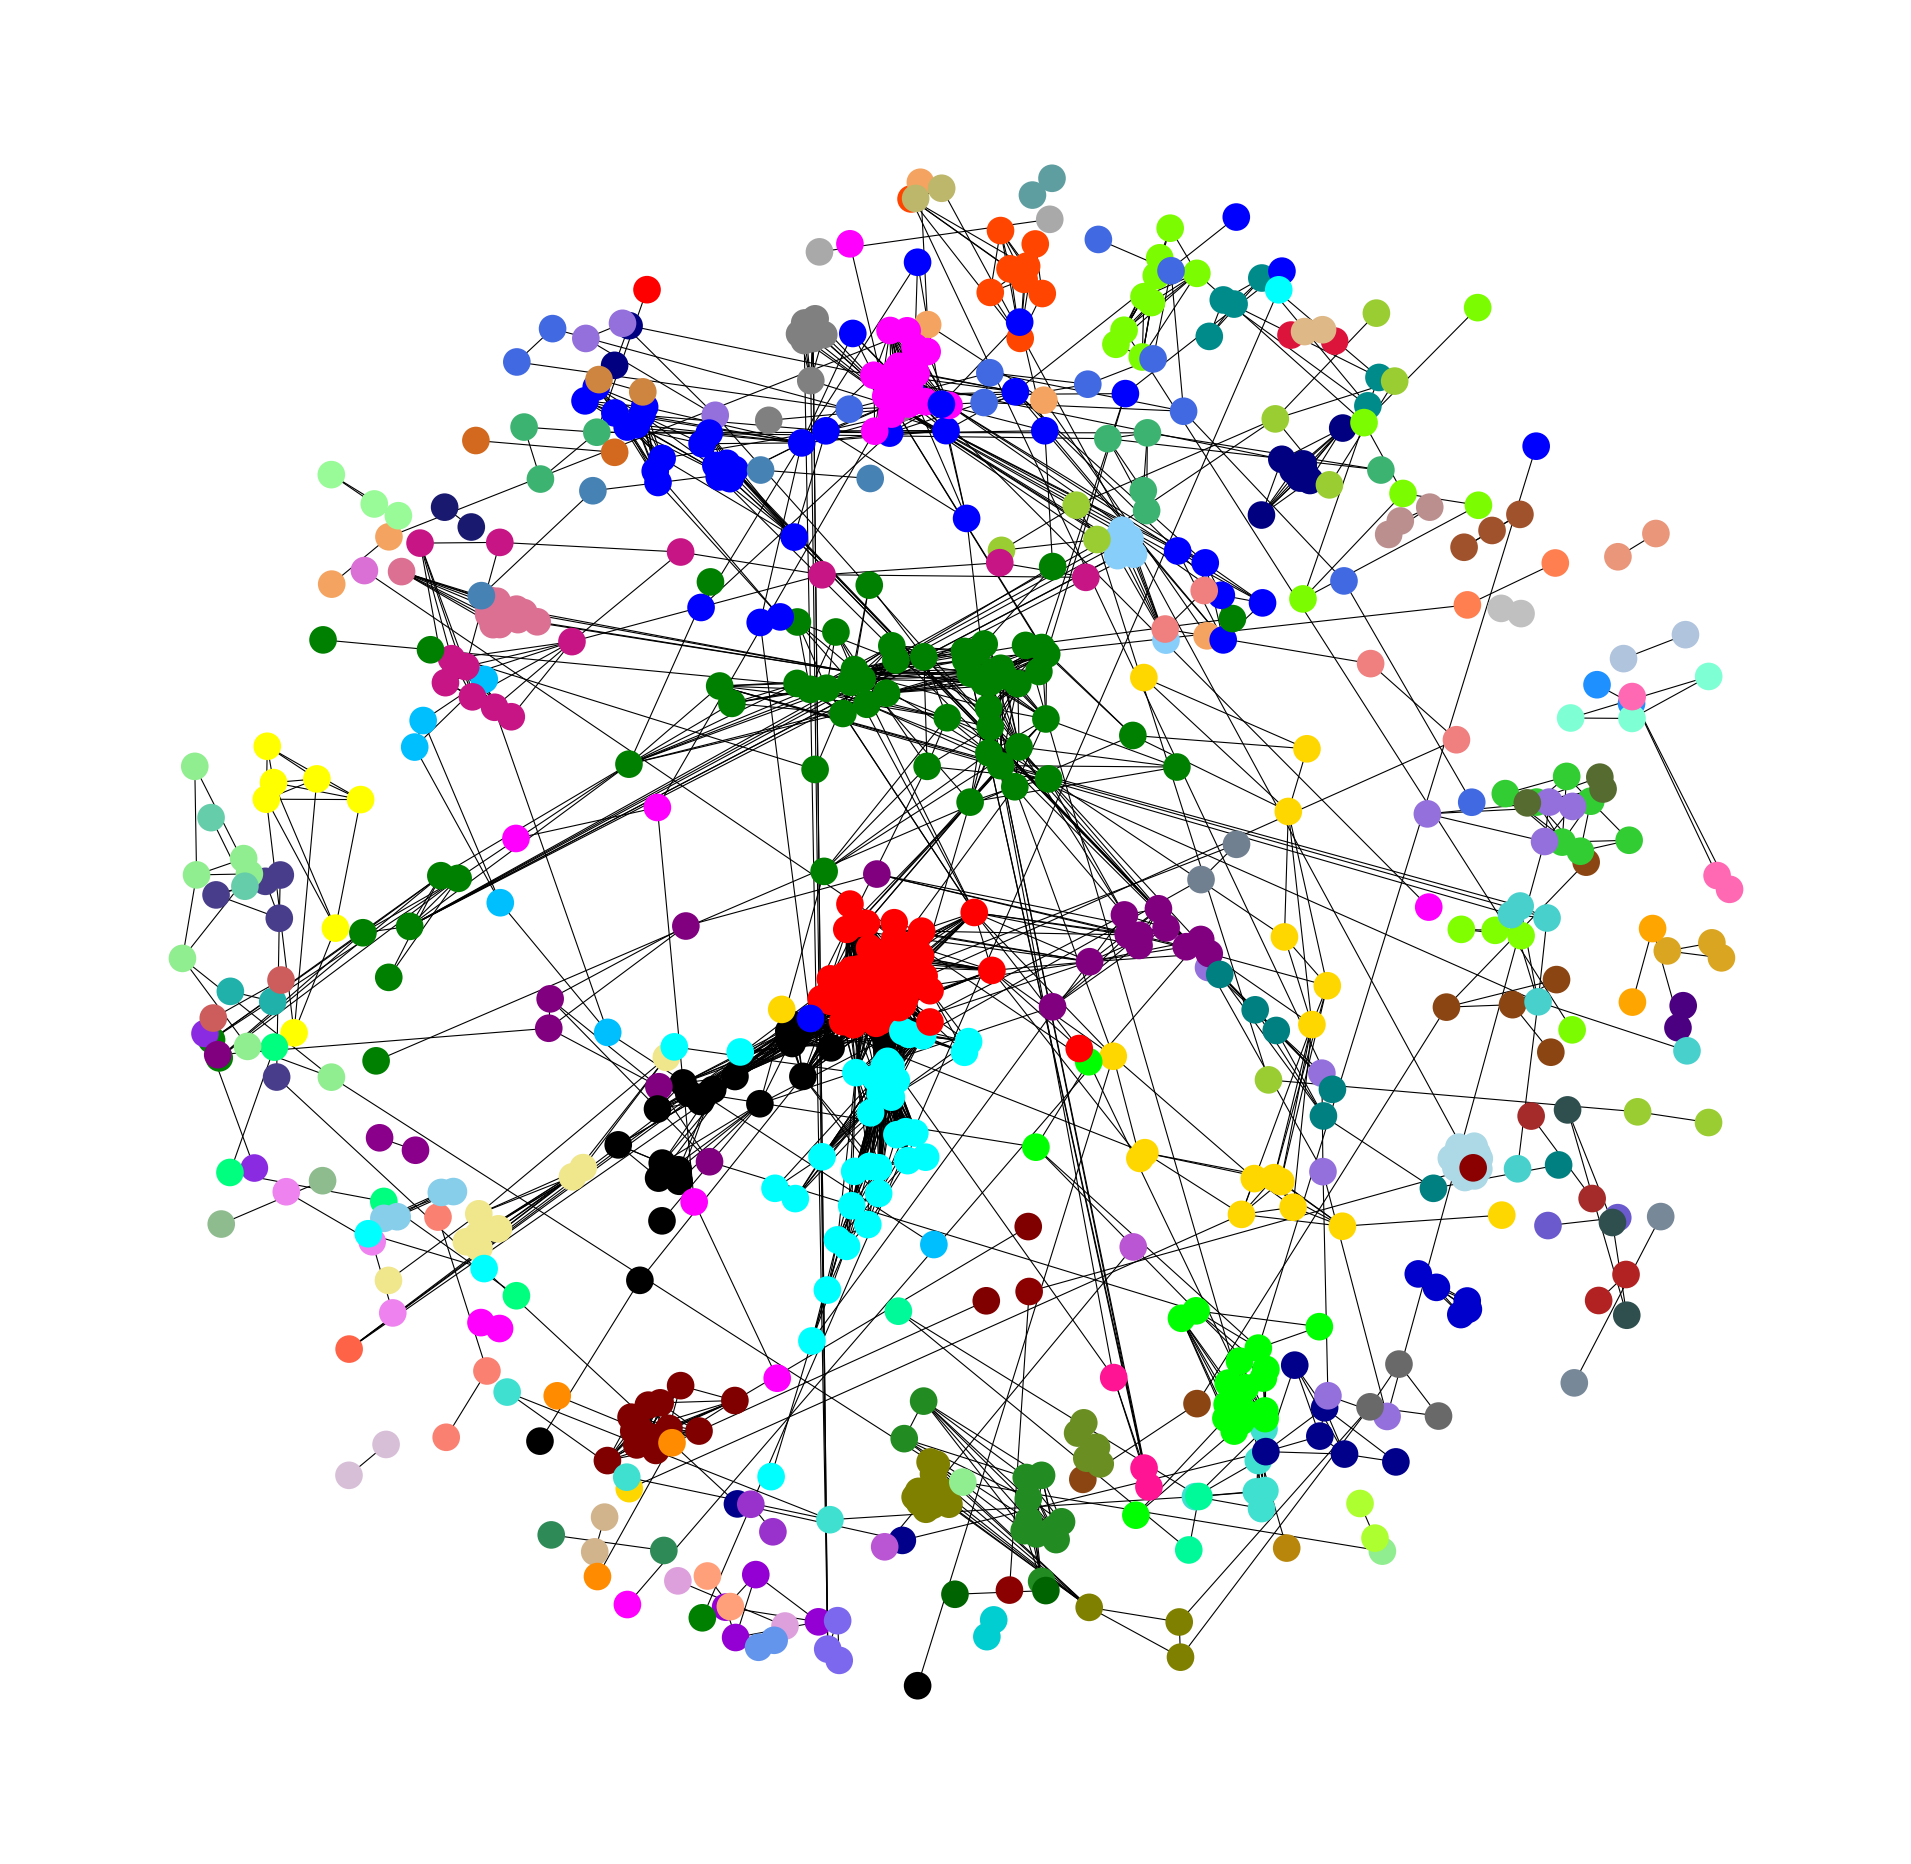

In [787]:
#Plot for louvain clustering
partition= community_louvain.best_partition(G,resolution=0.9)
print("Clusters: " + str(len(pd.Series(partition.values()).value_counts())))
print("Amount clonotypes: " + str(len(partition)))

# Change partition such that cluster Id is in descending order based on community size
partitions_by_cluster_size =list(pd.Series(partition.values()).value_counts().index)
partition_reorder = {cluster_id:rank for cluster_id,rank in zip(partitions_by_cluster_size,
                                                     range(len(partitions_by_cluster_size)))}

partition = {k:partition_reorder.get(v) for k,v in partition.items()}

clusters = [i for i in pd.Series(partition.values()).value_counts().index]
colors = get_html_colors(len(clusters))
cluster_to_color = {cluster:color for cluster,color, in zip(clusters,colors)}
options = {"edgecolors": None,"node_size": 80, "width": 0.4}

k2 = (1/sqrt((len(G.nodes))))*2

k_list=[k2]
k_names = ['k2']

for name, k_value in zip(k_names,k_list):
    fig, ax = plt.subplots(figsize=(12,12))
    
    pos = nx.spring_layout(G, seed=2, k = k_value, weight='weight')
    nx.draw(G,
                nodelist = G.nodes,
                pos = pos,
                node_color=[cluster_to_color.get(partition.get(i)) for i in G.nodes],
                ax = ax,
                **options)
    
    nodes = list(G.nodes)
    xpos = ax.get_children()[0].get_offsets().data[:,0].tolist()
    ypos = ax.get_children()[0].get_offsets().data[:,1].tolist()
    x_dict = dict(zip(nodes,xpos))
    y_dict = dict(zip(nodes,ypos))
    
    clone_df = pd.read_csv('./analysis_output/tcrdist/selected/clone_df_all_siinfekl.csv')
    clone_df['xpos'] = [str(x_dict.get(i)) if x_dict.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['ypos'] = [str(y_dict.get(i)) if y_dict.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['cluster_alpha_beta'] = [str(partition.get(i)) if partition.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['xpos'] = clone_df["xpos"].map(float)
    clone_df['ypos'] = clone_df["ypos"].map(float)
    clone_df.to_csv('./analysis_output/tcrdist/selected/'+ edge_attr + name + '_all_siinfekl_clone_df_with_clusters.csv', sep =",", index = False)
    
    plt.savefig('./analysis_output/tcr_clusters/selected/'+ edge_attr + name +'_all_siinfekl_tcr_dist_network.png', dpi=600, bbox_inches='tight')
    #plt.close()

Plotting of Isolation method

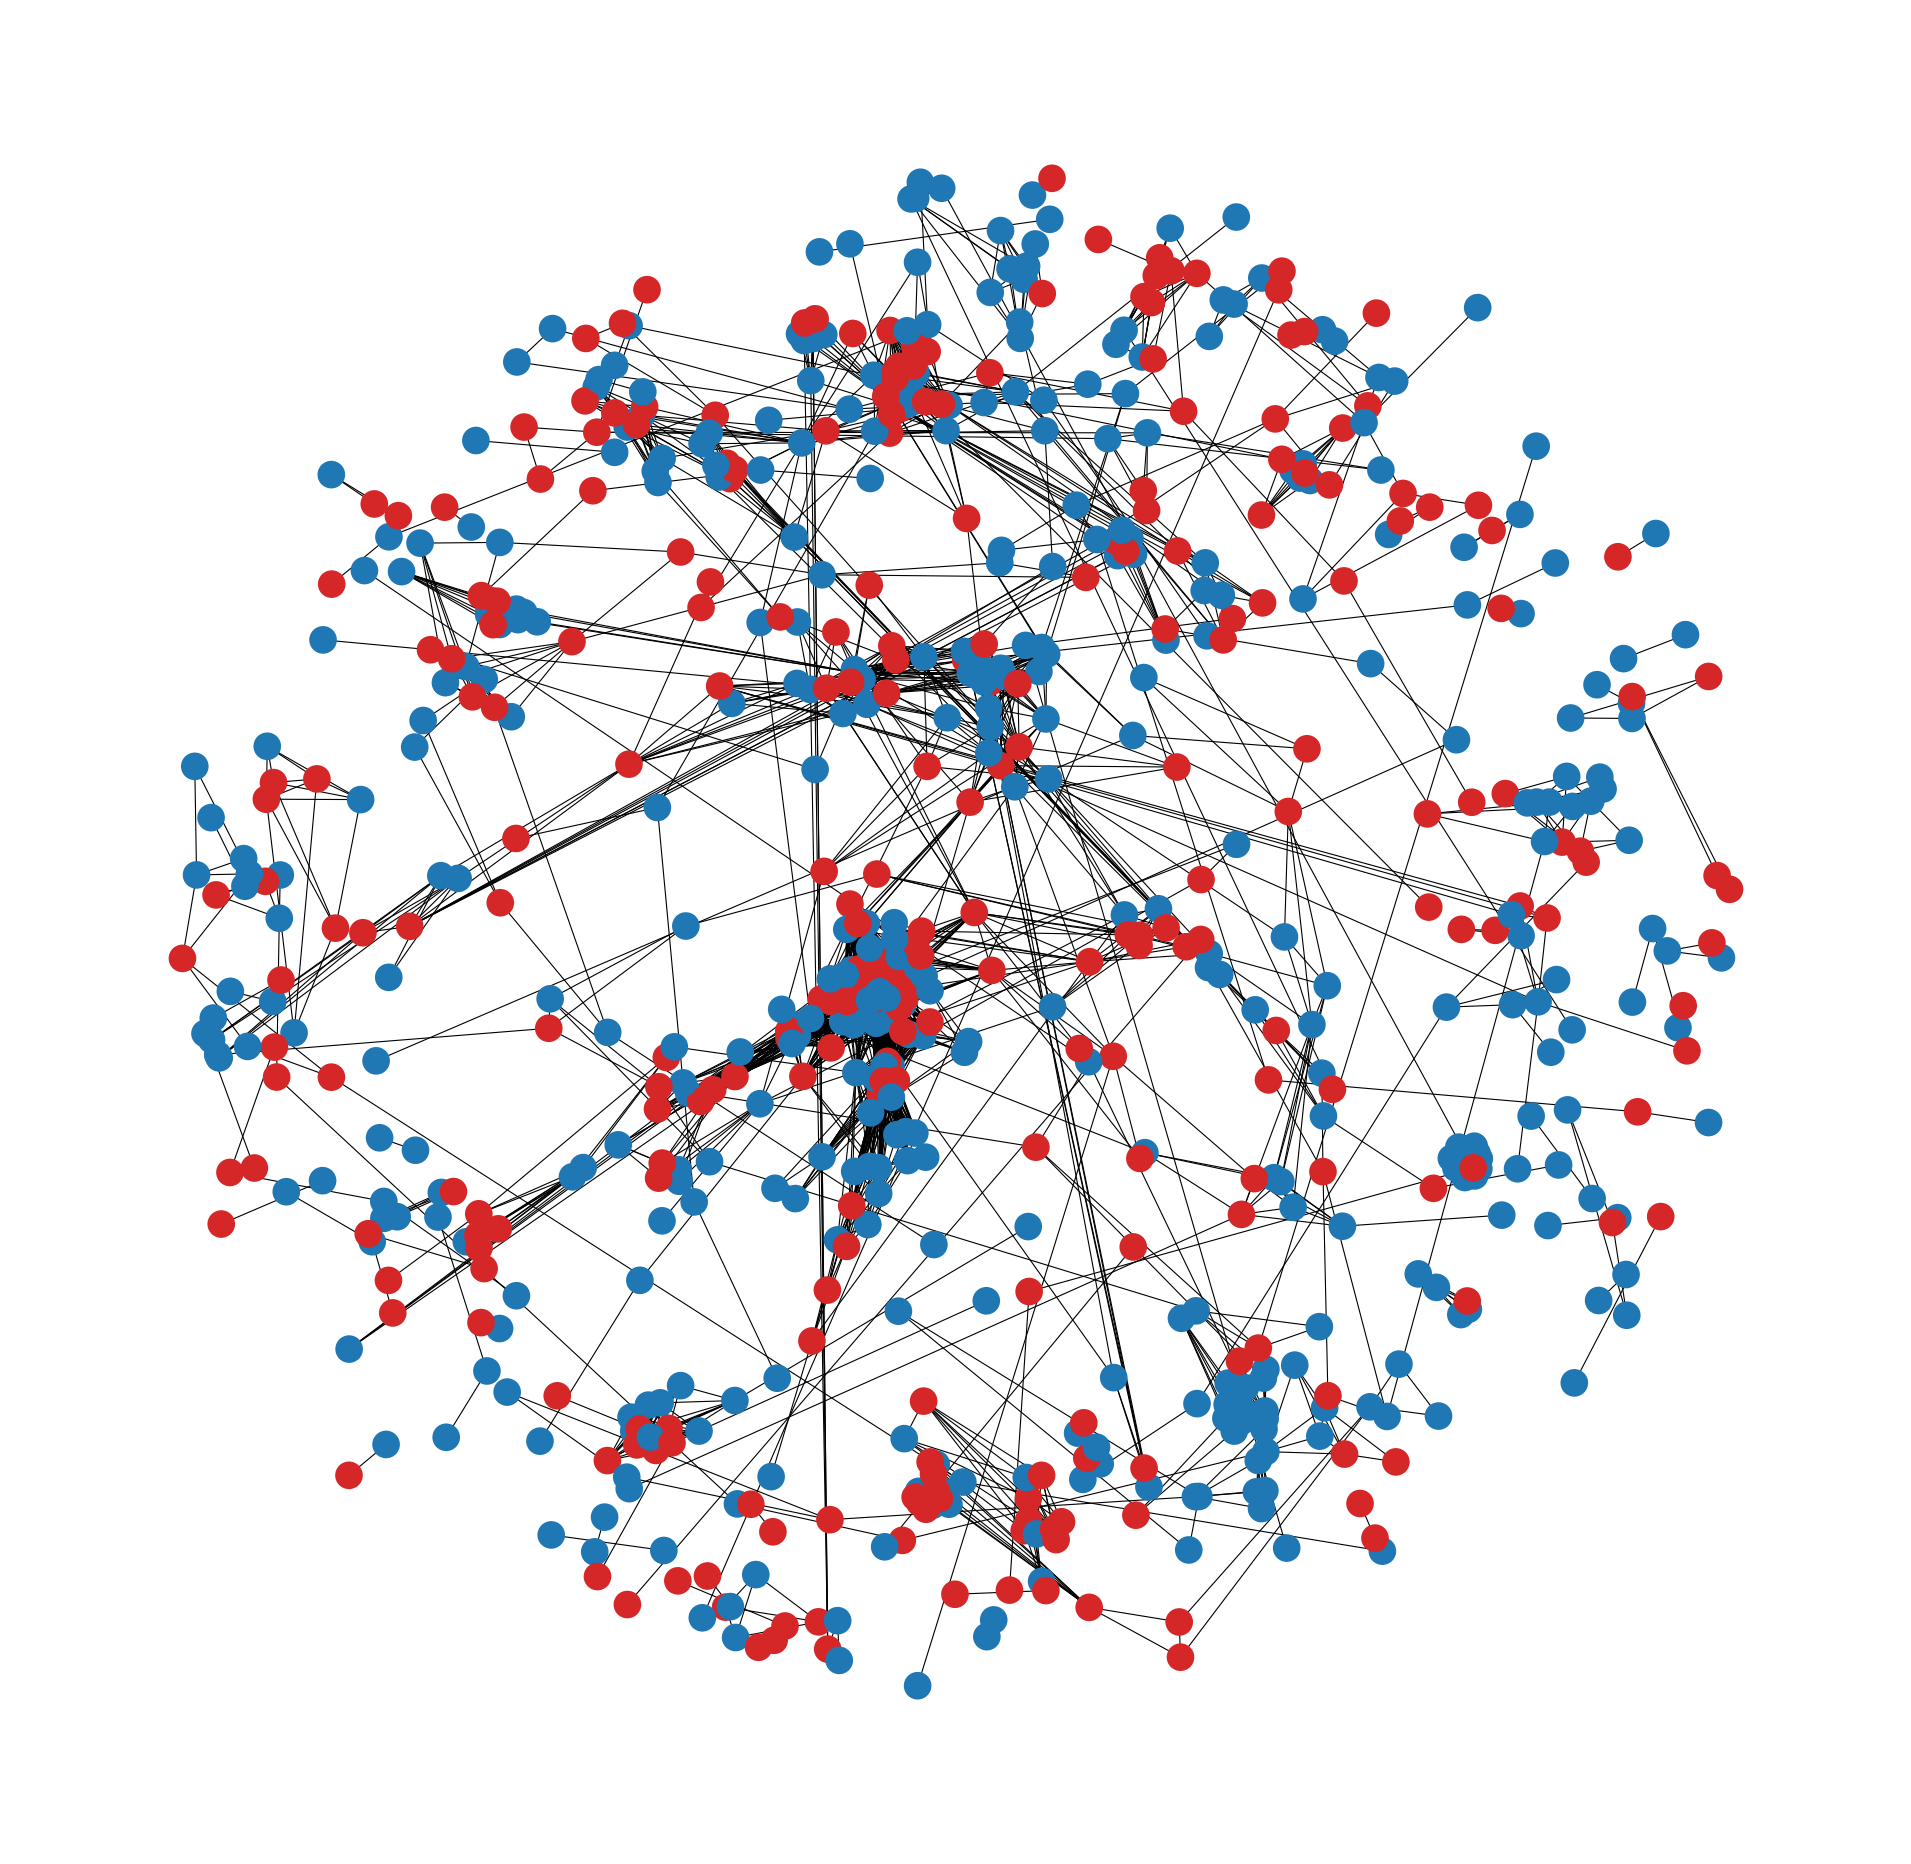

In [788]:
#Plot for isolation
isolation_methods = ['cd44','multimer']
colors = ['tab:blue','tab:red']
isolation_to_color = {isolation:color for isolation,color, in zip(isolation_methods,colors)}
node_colors = {node: isolation_to_color.get(isolation) for node, isolation in 
                       zip(df_net['node_1'],df_net['isolation_1'])}
options = {"edgecolors": None,"node_size": 80, "width": 0.4}

k2 = (1/sqrt((len(G.nodes))))*2

k_list=[k2]
k_names = ['k2']

for name, k_value in zip(k_names,k_list):
    fig, ax = plt.subplots(figsize=(12,12))
    
    pos = nx.spring_layout(G, seed=2, k = k_value, weight='weight')
    nx.draw(G,
                nodelist = G.nodes,
                pos = pos,
                node_color= [node_colors[node] for node in G.nodes],
                ax = ax,
                **options)
    
    plt.savefig('./analysis_output/tcr_clusters/selected/cd44_vs_mult_all_siinfekl_tcr_dist_network.png', dpi=600, bbox_inches='tight')


In [227]:
clone_df = pd.read_csv('./analysis_output/tcrdist/selected/tcr_dist_120_k2_all_siinfekl_clone_df_with_clusters.csv')

In [234]:
cluster_list = clone_df.cluster_alpha_beta.unique().tolist()

In [254]:
cluster_list.sort()

In [285]:
cd44_count_list = []
multimer_count_list = []
for cluster in cluster_list:
    cd44_count = clone_df.isolation[np.logical_and(clone_df.cluster_alpha_beta==cluster,clone_df.isolation=='cd44')].count()
    cd44_count_list.append(cd44_count)
    multimer_count = clone_df.isolation[np.logical_and(clone_df.cluster_alpha_beta==cluster,clone_df.isolation=='multimer')].count()
    multimer_count_list.append(multimer_count)

In [311]:
data = {'cluster': cluster_list, 'cd44': cd44_count_list, 'multimer': multimer_count_list}
df = pd.DataFrame(data)

In [313]:
df.to_csv('./analysis_output/tcrdist/selected/cluster_isolation_distribution.csv')

### For cd44 only

In [314]:
df_net = pd.read_csv('./analysis_output/tcrdist/selected/cd44_df_net.csv')
edge_threshold = 120
#df_net = df_net[df_net.dist<101]
#df_net['public'] =df_net.apply(lambda x : x['subject_1'] !=x['subject_2'], axis = 1)
#df_net['consistent'] = df_net.apply(lambda x : x['epitope_1'] ==x['epitope_2'], axis = 1)
df_net['weight'] = (edge_threshold - df_net['dist'])/edge_threshold
weight_dict = dict(zip(list(zip(df_net.node_1, df_net.node_2)), df_net.weight))

In [315]:
edge_attr = 'tcr_dist_120_'

With weight

In [316]:
G = nx.from_pandas_edgelist(
            pd.DataFrame({'source':df_net['node_1'],
                          'target':df_net['node_2'],
                          #'weight':df_net['weight'],
                         }))
nx.set_edge_attributes(G, values = weight_dict, name = 'weight')

Clusters: 86
Amount clonotypes: 423


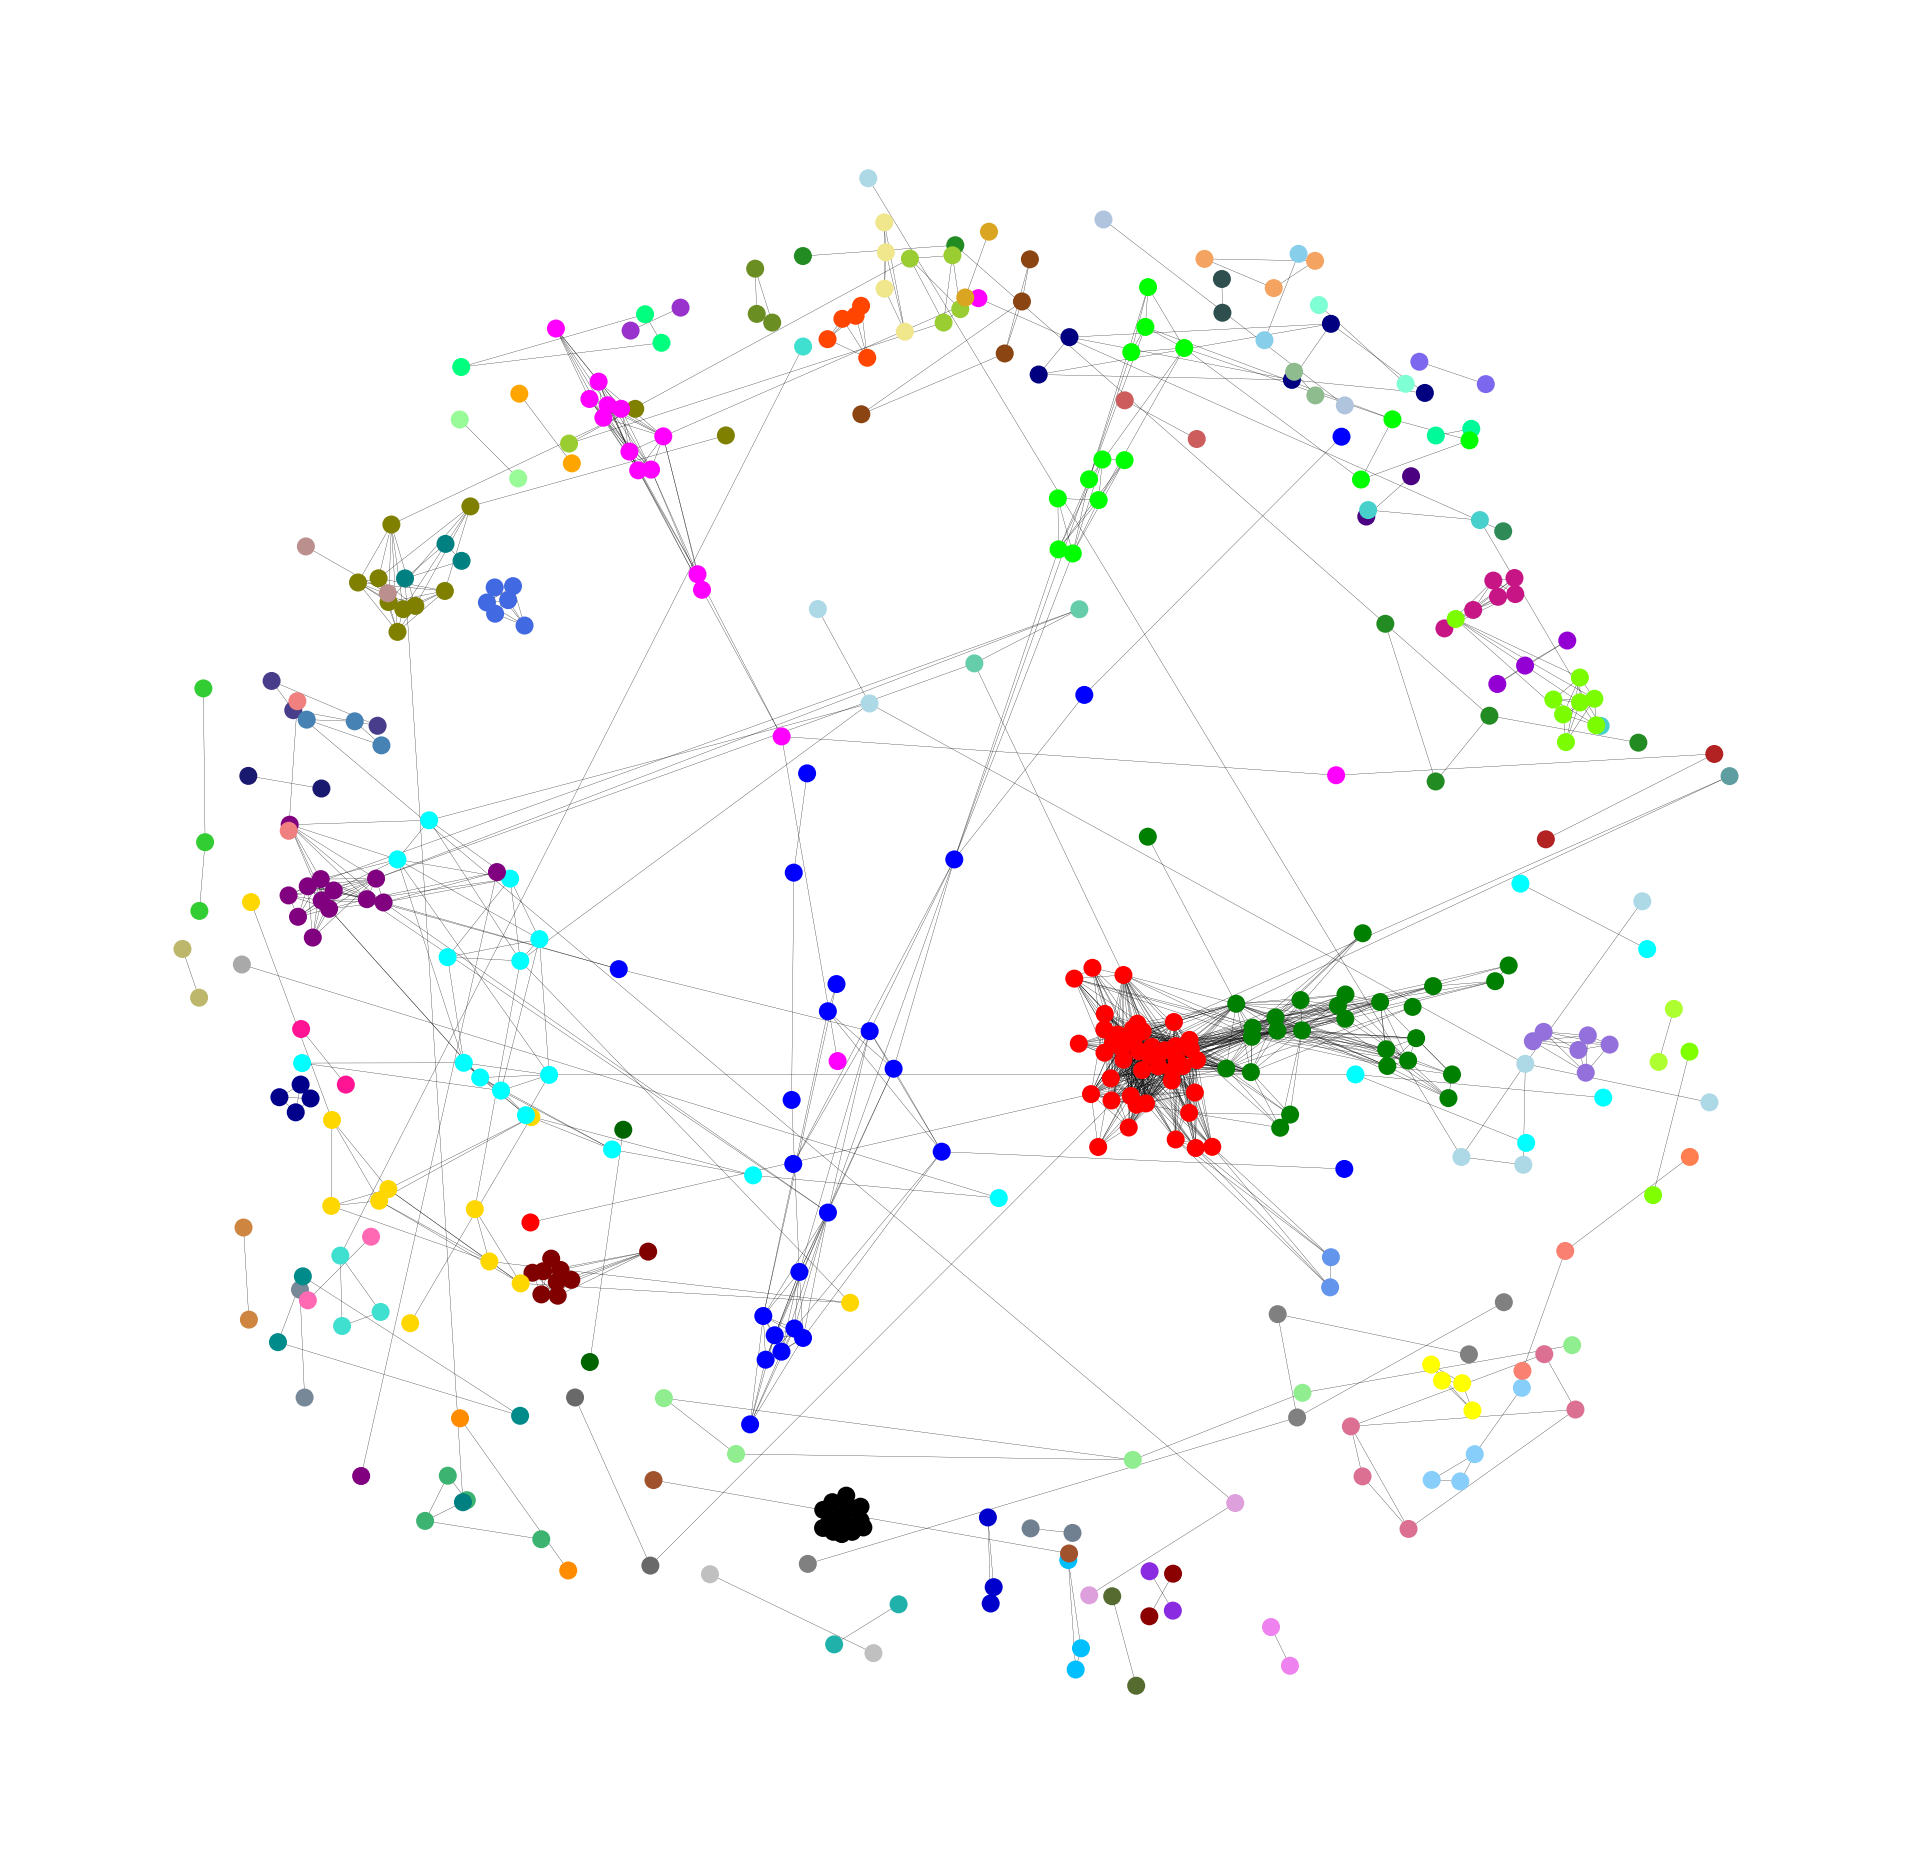

In [318]:
#Plot for louvain clustering
partition= community_louvain.best_partition(G)
print("Clusters: " + str(len(pd.Series(partition.values()).value_counts())))
print("Amount clonotypes: " + str(len(partition)))

# Change partition such that cluster Id is in descending order based on community size
partitions_by_cluster_size =list(pd.Series(partition.values()).value_counts().index)
partition_reorder = {cluster_id:rank for cluster_id,rank in zip(partitions_by_cluster_size,
                                                     range(len(partitions_by_cluster_size)))}

partition = {k:partition_reorder.get(v) for k,v in partition.items()}

clusters = [i for i in pd.Series(partition.values()).value_counts().index]
colors = get_html_colors(len(clusters))
cluster_to_color = {cluster:color for cluster,color, in zip(clusters,colors)}
options = {"edgecolors": None,"node_size": 30, "width": 0.1}

k2 = (1/sqrt((len(G.nodes))))*2

k_list=[k2]
k_names = ['k2']

for name, k_value in zip(k_names,k_list):
    fig, ax = plt.subplots(figsize=(12,12))
    
    pos = nx.spring_layout(G, seed=2, k = k_value, weight='weight')
    nx.draw(G,
                nodelist = G.nodes,
                pos = pos,
                node_color=[cluster_to_color.get(partition.get(i)) for i in G.nodes],
                ax = ax,
                **options)
    
    nodes = list(G.nodes)
    xpos = ax.get_children()[0].get_offsets().data[:,0].tolist()
    ypos = ax.get_children()[0].get_offsets().data[:,1].tolist()
    x_dict = dict(zip(nodes,xpos))
    y_dict = dict(zip(nodes,ypos))
    
    clone_df = pd.read_csv('./analysis_output/tcrdist/selected/clone_df_cd44.csv')
    clone_df['xpos'] = [str(x_dict.get(i)) if x_dict.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['ypos'] = [str(y_dict.get(i)) if y_dict.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['cluster_alpha_beta'] = [str(partition.get(i)) if partition.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['xpos'] = clone_df["xpos"].map(float)
    clone_df['ypos'] = clone_df["ypos"].map(float)
    clone_df.to_csv('./analysis_output/tcrdist/selected/'+ edge_attr + name + '_cd44_clone_df_with_clusters.csv', sep =",", index = False)
    
    plt.savefig('./analysis_output/tcr_clusters/selected/'+ edge_attr + name +'_cd44_tcr_dist_network.png', dpi=600, bbox_inches='tight')
    #plt.close()

### For multimer only

In [322]:
df_net = pd.read_csv('./analysis_output/tcrdist/selected/multimer_positive_df_net.csv')
edge_threshold = 120
#df_net = df_net[df_net.dist<101]
#df_net['public'] =df_net.apply(lambda x : x['subject_1'] !=x['subject_2'], axis = 1)
#df_net['consistent'] = df_net.apply(lambda x : x['epitope_1'] ==x['epitope_2'], axis = 1)
df_net['weight'] = (edge_threshold - df_net['dist'])/edge_threshold
weight_dict = dict(zip(list(zip(df_net.node_1, df_net.node_2)), df_net.weight))

In [323]:
G = nx.from_pandas_edgelist(
            pd.DataFrame({'source':df_net['node_1'],
                          'target':df_net['node_2'],
                          #'weight':df_net['weight'],
                         }))
nx.set_edge_attributes(G, values = weight_dict, name = 'weight')

Clusters: 58
Amount clonotypes: 247


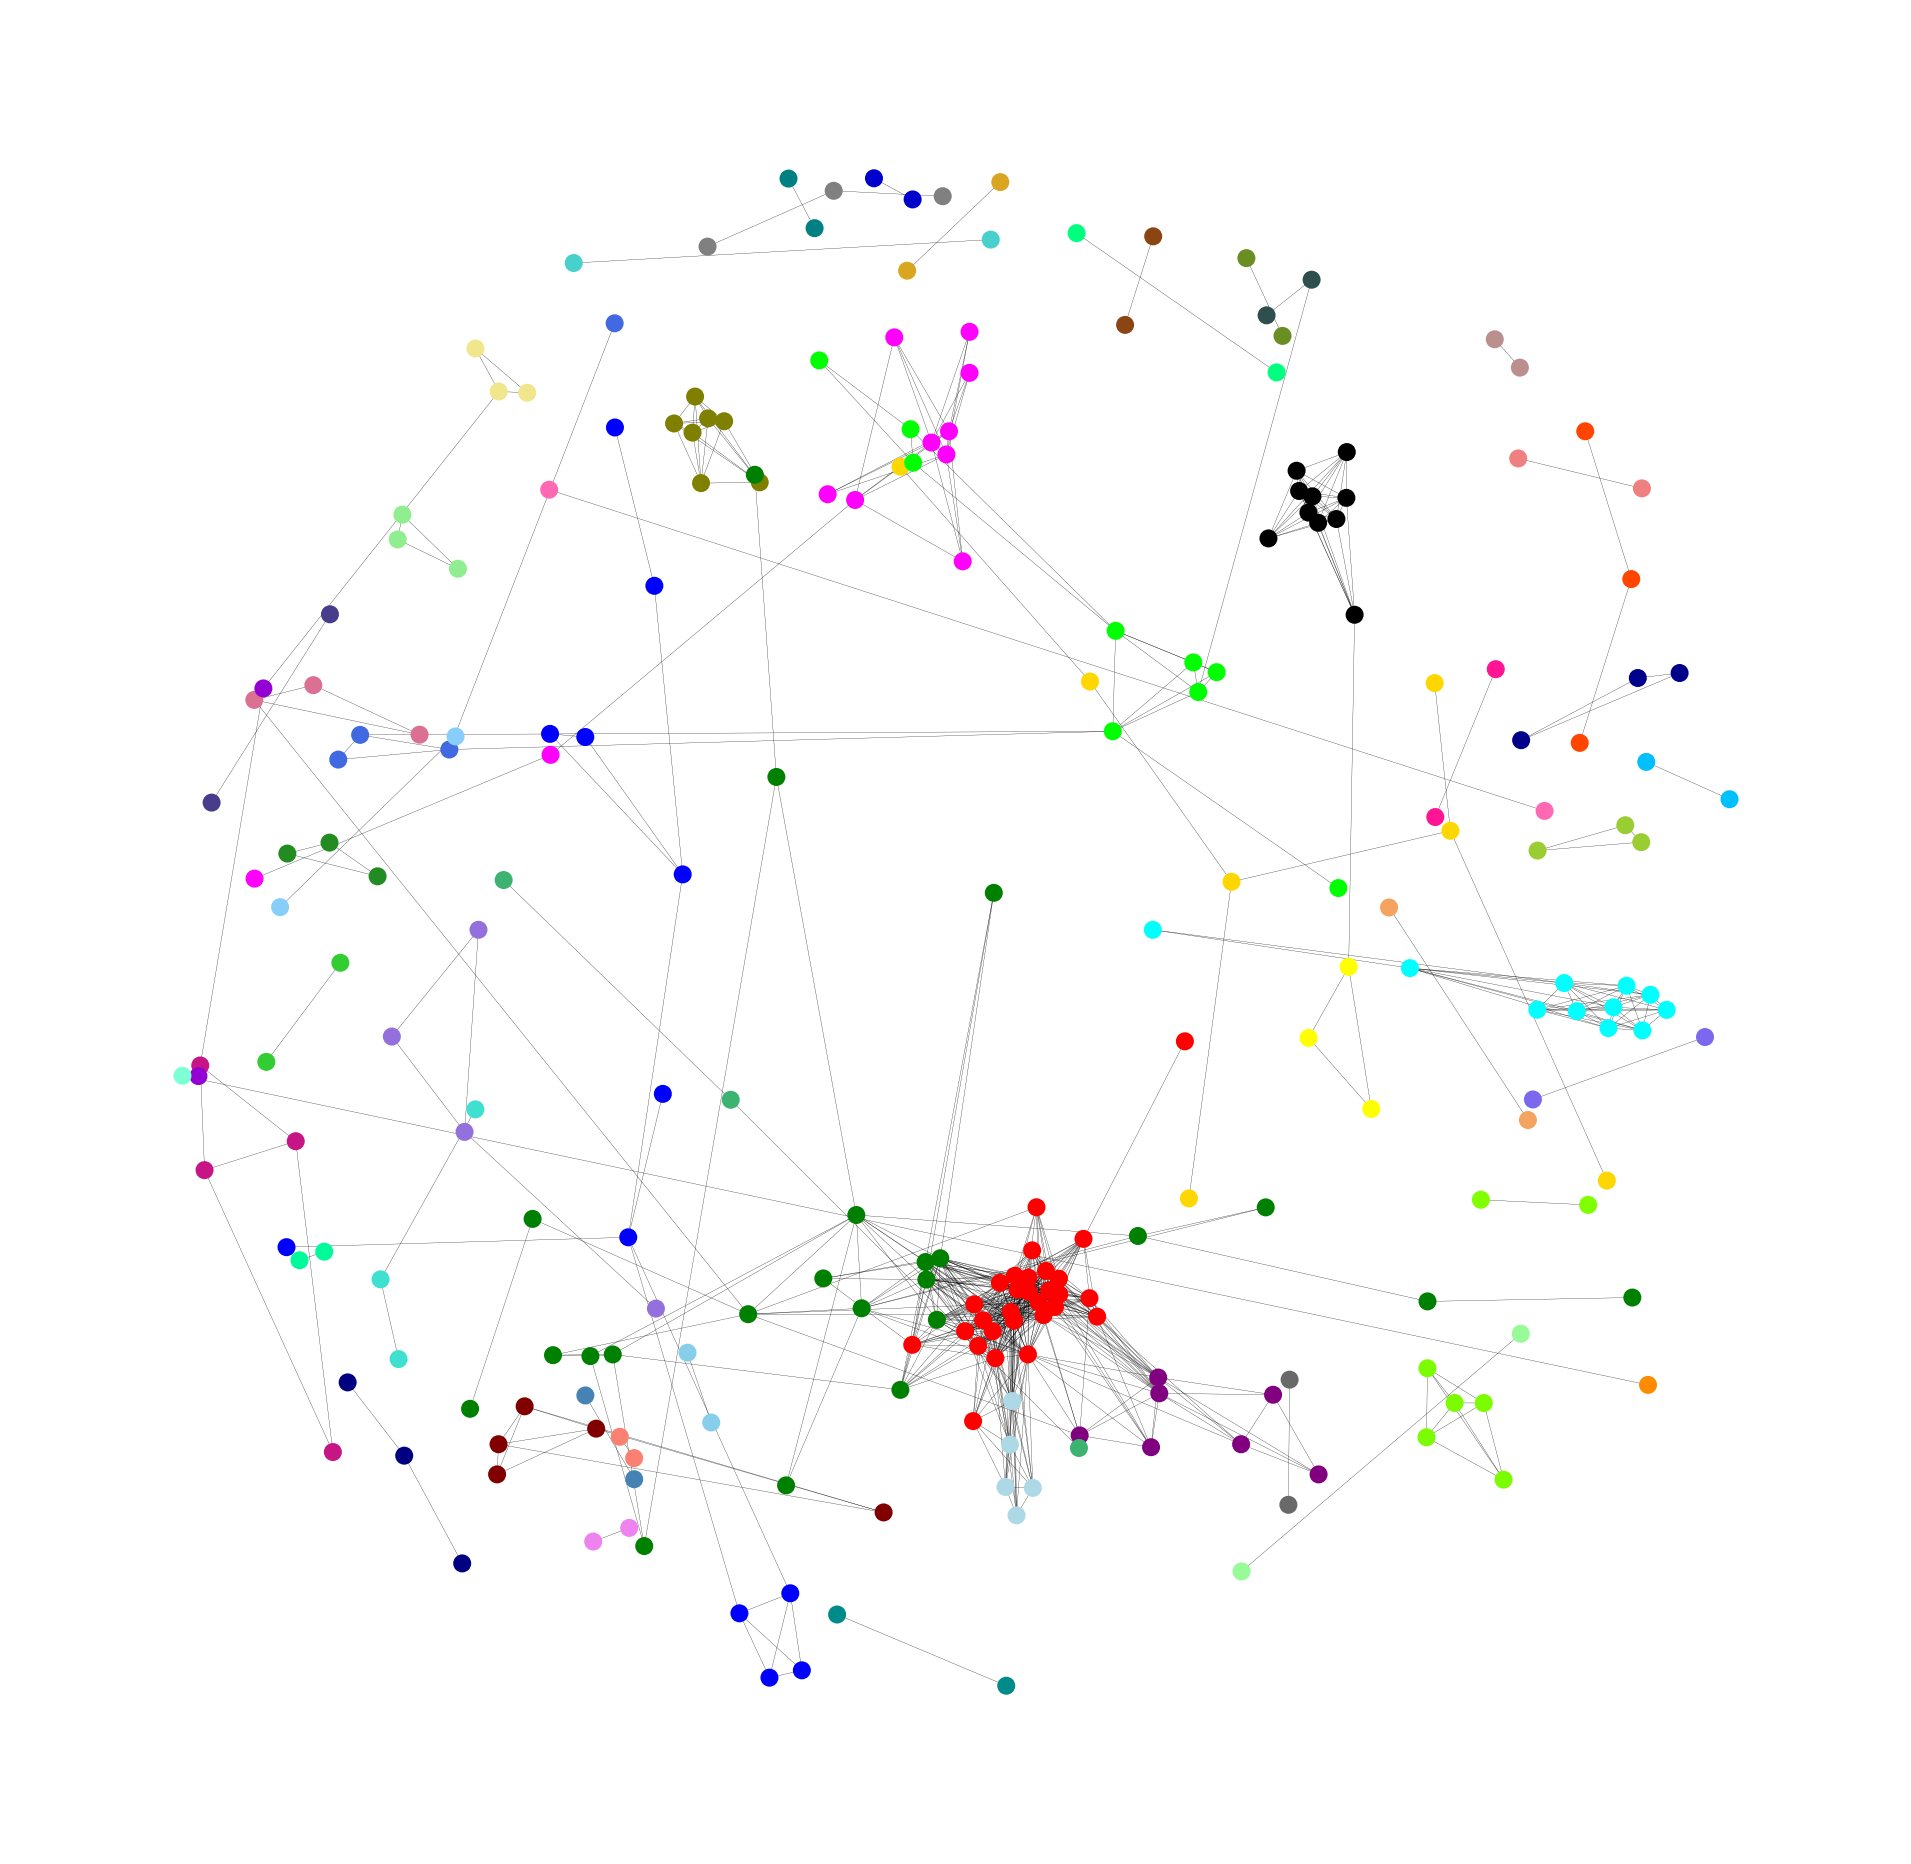

In [324]:
#Plot for louvain clustering
partition= community_louvain.best_partition(G)
print("Clusters: " + str(len(pd.Series(partition.values()).value_counts())))
print("Amount clonotypes: " + str(len(partition)))

# Change partition such that cluster Id is in descending order based on community size
partitions_by_cluster_size =list(pd.Series(partition.values()).value_counts().index)
partition_reorder = {cluster_id:rank for cluster_id,rank in zip(partitions_by_cluster_size,
                                                     range(len(partitions_by_cluster_size)))}

partition = {k:partition_reorder.get(v) for k,v in partition.items()}

clusters = [i for i in pd.Series(partition.values()).value_counts().index]
colors = get_html_colors(len(clusters))
cluster_to_color = {cluster:color for cluster,color, in zip(clusters,colors)}
options = {"edgecolors": None,"node_size": 30, "width": 0.1}

k2 = (1/sqrt((len(G.nodes))))*2

k_list=[k2]
k_names = ['k2']

for name, k_value in zip(k_names,k_list):
    fig, ax = plt.subplots(figsize=(12,12))
    
    pos = nx.spring_layout(G, seed=2, k = k_value, weight='weight')
    nx.draw(G,
                nodelist = G.nodes,
                pos = pos,
                node_color=[cluster_to_color.get(partition.get(i)) for i in G.nodes],
                ax = ax,
                **options)
    
    nodes = list(G.nodes)
    xpos = ax.get_children()[0].get_offsets().data[:,0].tolist()
    ypos = ax.get_children()[0].get_offsets().data[:,1].tolist()
    x_dict = dict(zip(nodes,xpos))
    y_dict = dict(zip(nodes,ypos))
    
    clone_df = pd.read_csv('./analysis_output/tcrdist/selected/clone_df_multimer_positive.csv')
    clone_df['xpos'] = [str(x_dict.get(i)) if x_dict.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['ypos'] = [str(y_dict.get(i)) if y_dict.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['cluster_alpha_beta'] = [str(partition.get(i)) if partition.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['xpos'] = clone_df["xpos"].map(float)
    clone_df['ypos'] = clone_df["ypos"].map(float)
    clone_df.to_csv('./analysis_output/tcrdist/selected/'+ edge_attr + name + '_multimer_positive_clone_df_with_clusters.csv', sep =",", index = False)
    
    plt.savefig('./analysis_output/tcr_clusters/selected/'+ edge_attr + name +'_multimer_positive_tcr_dist_network.png', dpi=600, bbox_inches='tight')
    #plt.close()

Plot all clonotypes network

In [483]:
df = df_clonotypes_all.reset_index()[['subject','epitope','cdr3_a_aa',
                          'v_a_gene','j_a_gene','cdr3_b_aa',
                          'v_b_gene','j_b_gene',
                          'cdr3a_nt','cdr3b_nt','count','clonotype_origin','count_by_mouse','isolation']].copy()

In [484]:
tr_calc(df, filename='all',cdr3_a_aa_value=3,cdr3_b_aa_value=3,pmhc_a_aa_value=1,pmhc_b_aa_value=1)

tr_all = deepcopy(tr)

In [490]:
create_df_network(tr=tr, edge = 100, filename='all_df_net')

In [491]:
df_net = pd.read_csv('./analysis_output/tcrdist/selected/all_df_net.csv')
df_net = df_net[df_net.K_neighbors>50]
edge_threshold = 100
#df_net = df_net[df_net.dist<101]
#df_net['public'] =df_net.apply(lambda x : x['subject_1'] !=x['subject_2'], axis = 1)
#df_net['consistent'] = df_net.apply(lambda x : x['epitope_1'] ==x['epitope_2'], axis = 1)
df_net['weight'] = (edge_threshold - df_net['dist'])/edge_threshold
weight_dict = dict(zip(list(zip(df_net.node_1, df_net.node_2)), df_net.weight))
edge_attr = 'tcr_dist_100_'

G = nx.from_pandas_edgelist(
            pd.DataFrame({'source':df_net['node_1'],
                          'target':df_net['node_2'],
                          #'weight':df_net['weight'],
                         }))
nx.set_edge_attributes(G, values = weight_dict, name = 'weight')


Clusters: 107
Amount clonotypes: 6280


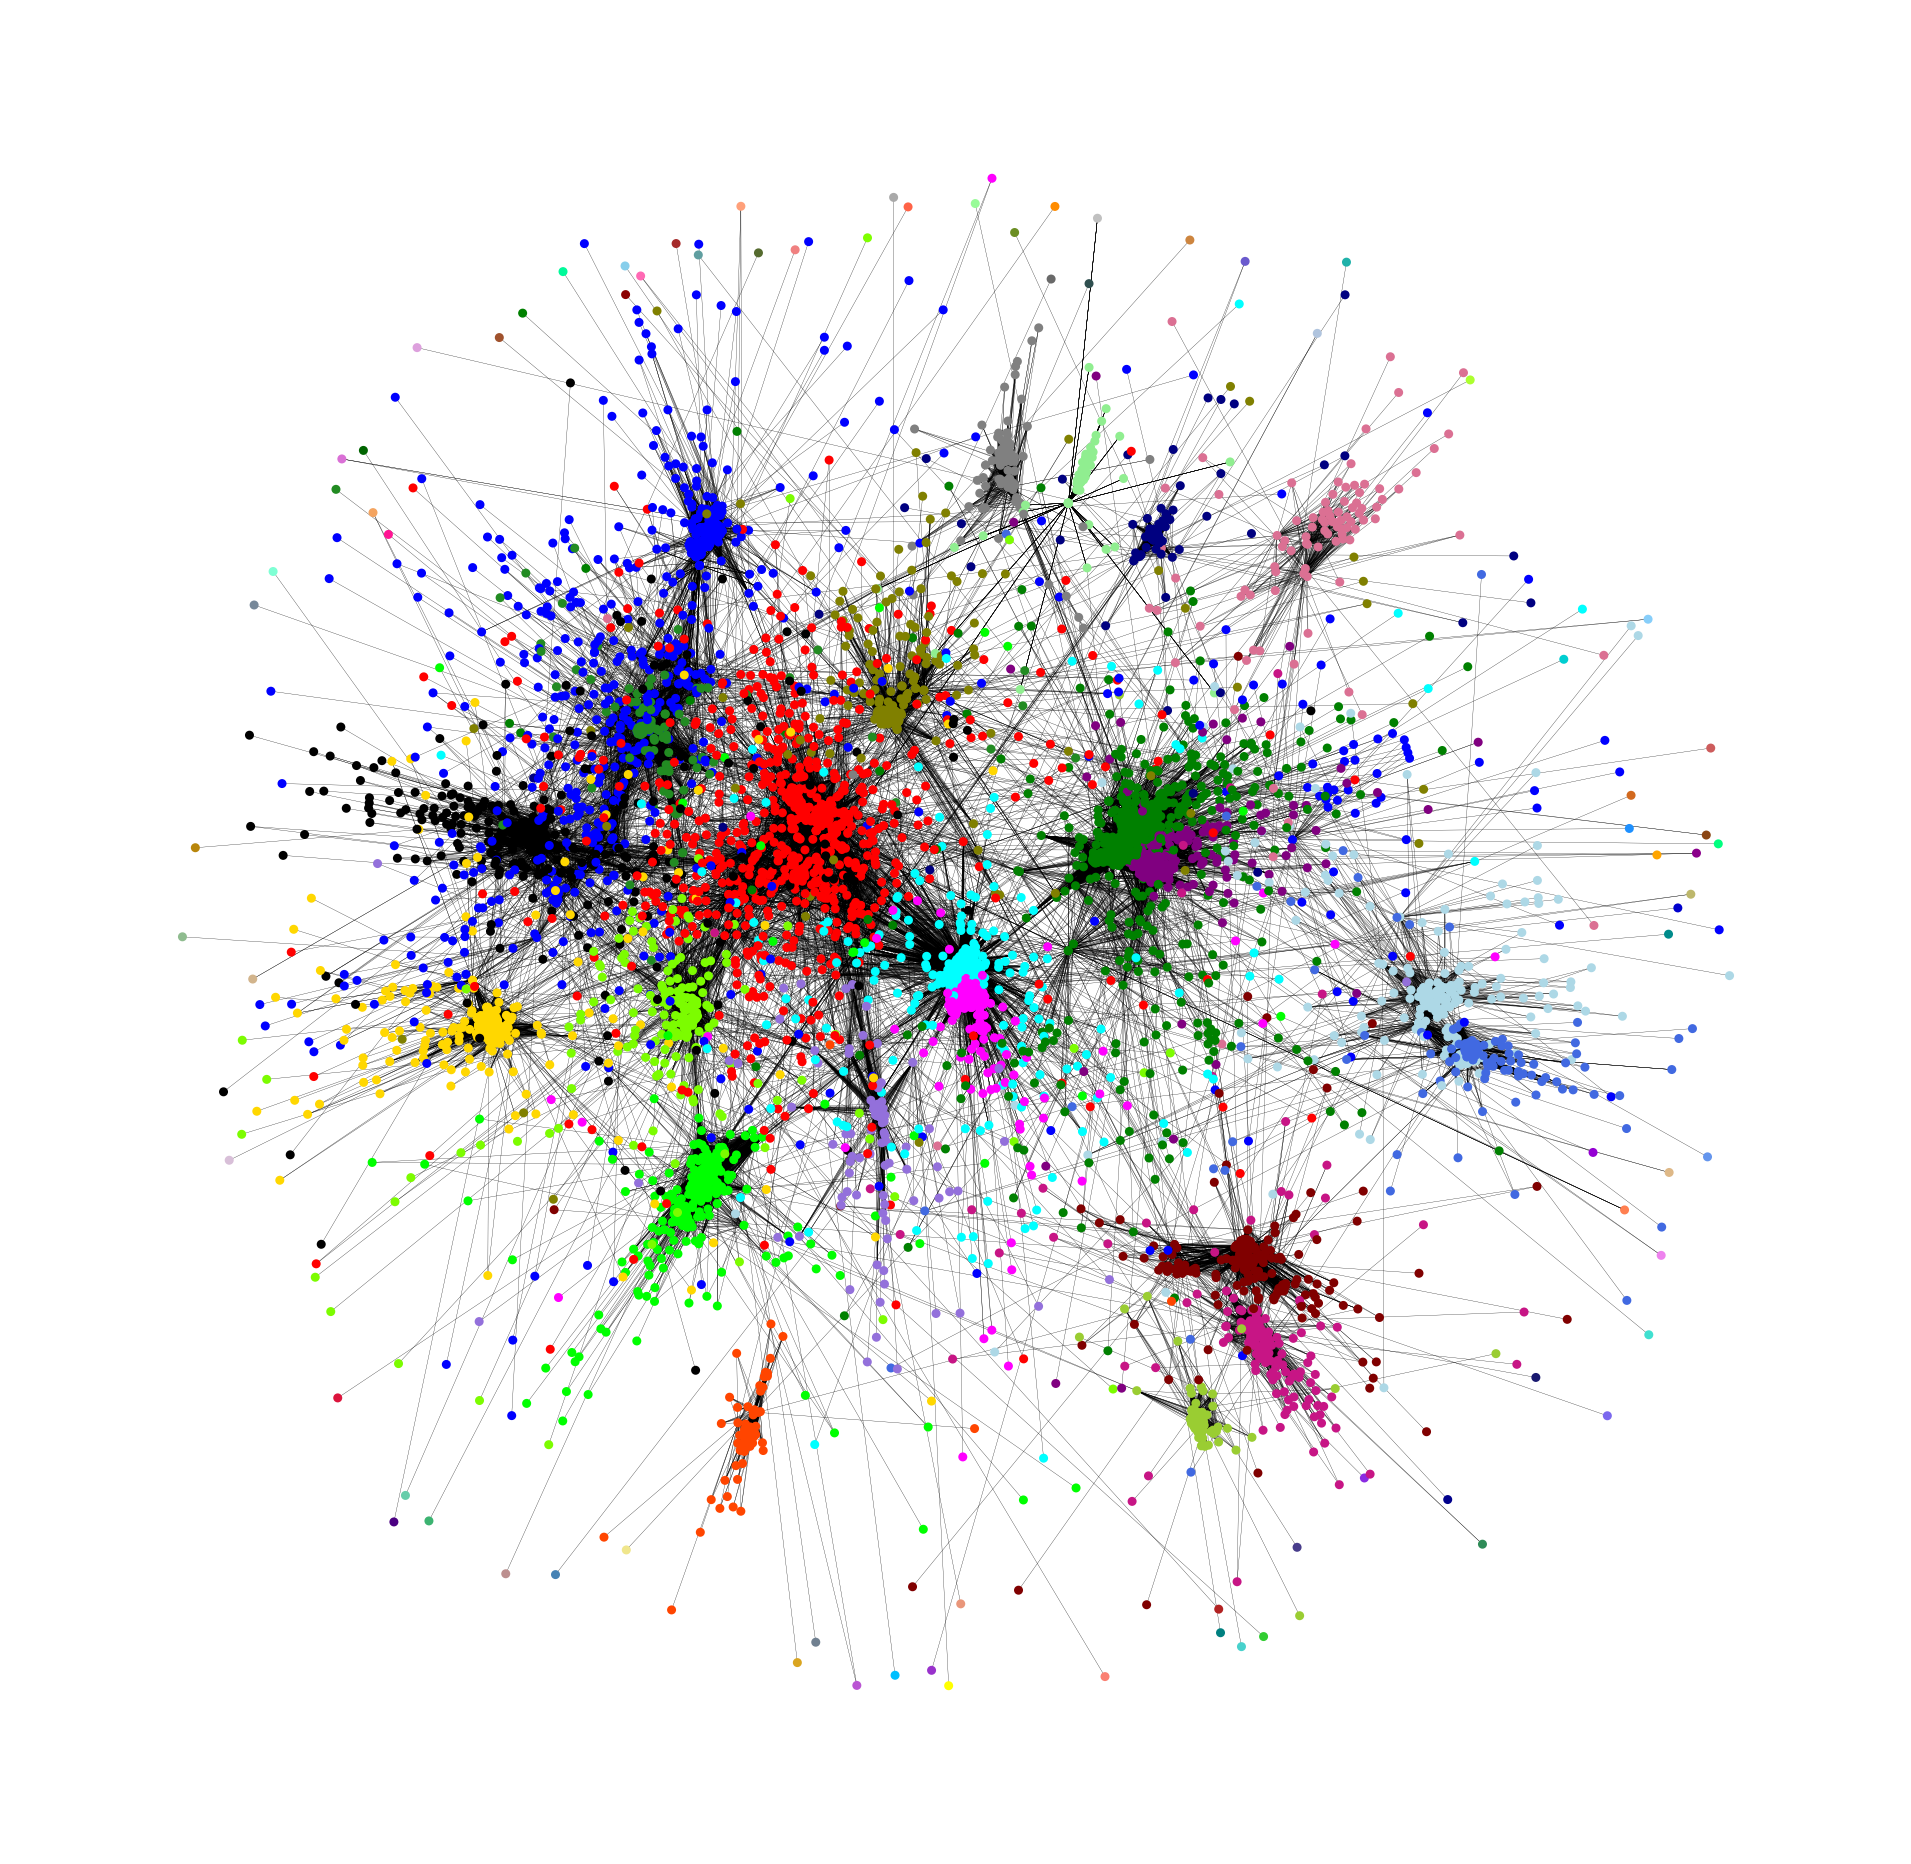

In [492]:
#Plot for louvain clustering
partition= community_louvain.best_partition(G,resolution=0.9)
print("Clusters: " + str(len(pd.Series(partition.values()).value_counts())))
print("Amount clonotypes: " + str(len(partition)))

# Change partition such that cluster Id is in descending order based on community size
partitions_by_cluster_size =list(pd.Series(partition.values()).value_counts().index)
partition_reorder = {cluster_id:rank for cluster_id,rank in zip(partitions_by_cluster_size,
                                                     range(len(partitions_by_cluster_size)))}

partition = {k:partition_reorder.get(v) for k,v in partition.items()}

clusters = [i for i in pd.Series(partition.values()).value_counts().index]
colors = get_html_colors(len(clusters))
cluster_to_color = {cluster:color for cluster,color, in zip(clusters,colors)}
options = {"edgecolors": None,"node_size": 5, "width": 0.1}

k2 = (1/sqrt((len(G.nodes))))*2

k_list=[k2]
k_names = ['k2']

for name, k_value in zip(k_names,k_list):
    fig, ax = plt.subplots(figsize=(12,12))
    
    pos = nx.spring_layout(G, seed=2, k = k_value, weight='weight')
    nx.draw(G,
                nodelist = G.nodes,
                pos = pos,
                node_color=[cluster_to_color.get(partition.get(i)) for i in G.nodes],
                ax = ax,
                **options)
    
    nodes = list(G.nodes)
    xpos = ax.get_children()[0].get_offsets().data[:,0].tolist()
    ypos = ax.get_children()[0].get_offsets().data[:,1].tolist()
    x_dict = dict(zip(nodes,xpos))
    y_dict = dict(zip(nodes,ypos))
    
    clone_df = pd.read_csv('./analysis_output/tcrdist/selected/clone_df_all.csv')
    clone_df['xpos'] = [str(x_dict.get(i)) if x_dict.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['ypos'] = [str(y_dict.get(i)) if y_dict.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['cluster_alpha_beta'] = [str(partition.get(i)) if partition.get(i) is not None else np.nan for i in clone_df.index]
    clone_df['xpos'] = clone_df["xpos"].map(float)
    clone_df['ypos'] = clone_df["ypos"].map(float)
    clone_df.to_csv('./analysis_output/tcrdist/selected/clone_df_all_with_clusters.csv', sep =",", index = False)
    
    plt.savefig('./analysis_output/tcr_clusters/selected/all_clones_tcr_dist_network.png', dpi=600, bbox_inches='tight')
    #plt.close()


In [517]:
clone_df = pd.read_csv('./analysis_output/tcrdist/selected/clone_df_all_with_clusters.csv')

In [518]:
multimer_clones = df_multimer.clonotype_origin.tolist()
cd44_clones = df_cd44.clonotype_origin.tolist()

In [519]:
clone_df['clonotype_origin'] = clone_df.clonotype_origin.astype(str)
clone_df['epitope_isolation'] = 'non_reactive'
clone_df.epitope_isolation[clone_df.clonotype_origin.isin(cd44_clones)] = 'cd44_reactive'
clone_df.epitope_isolation[clone_df.clonotype_origin.isin(multimer_clones)] = 'multimer_positive'

(-1.0246470868587494,
 1.0956859290599823,
 -1.097350251674652,
 1.044355285167694)

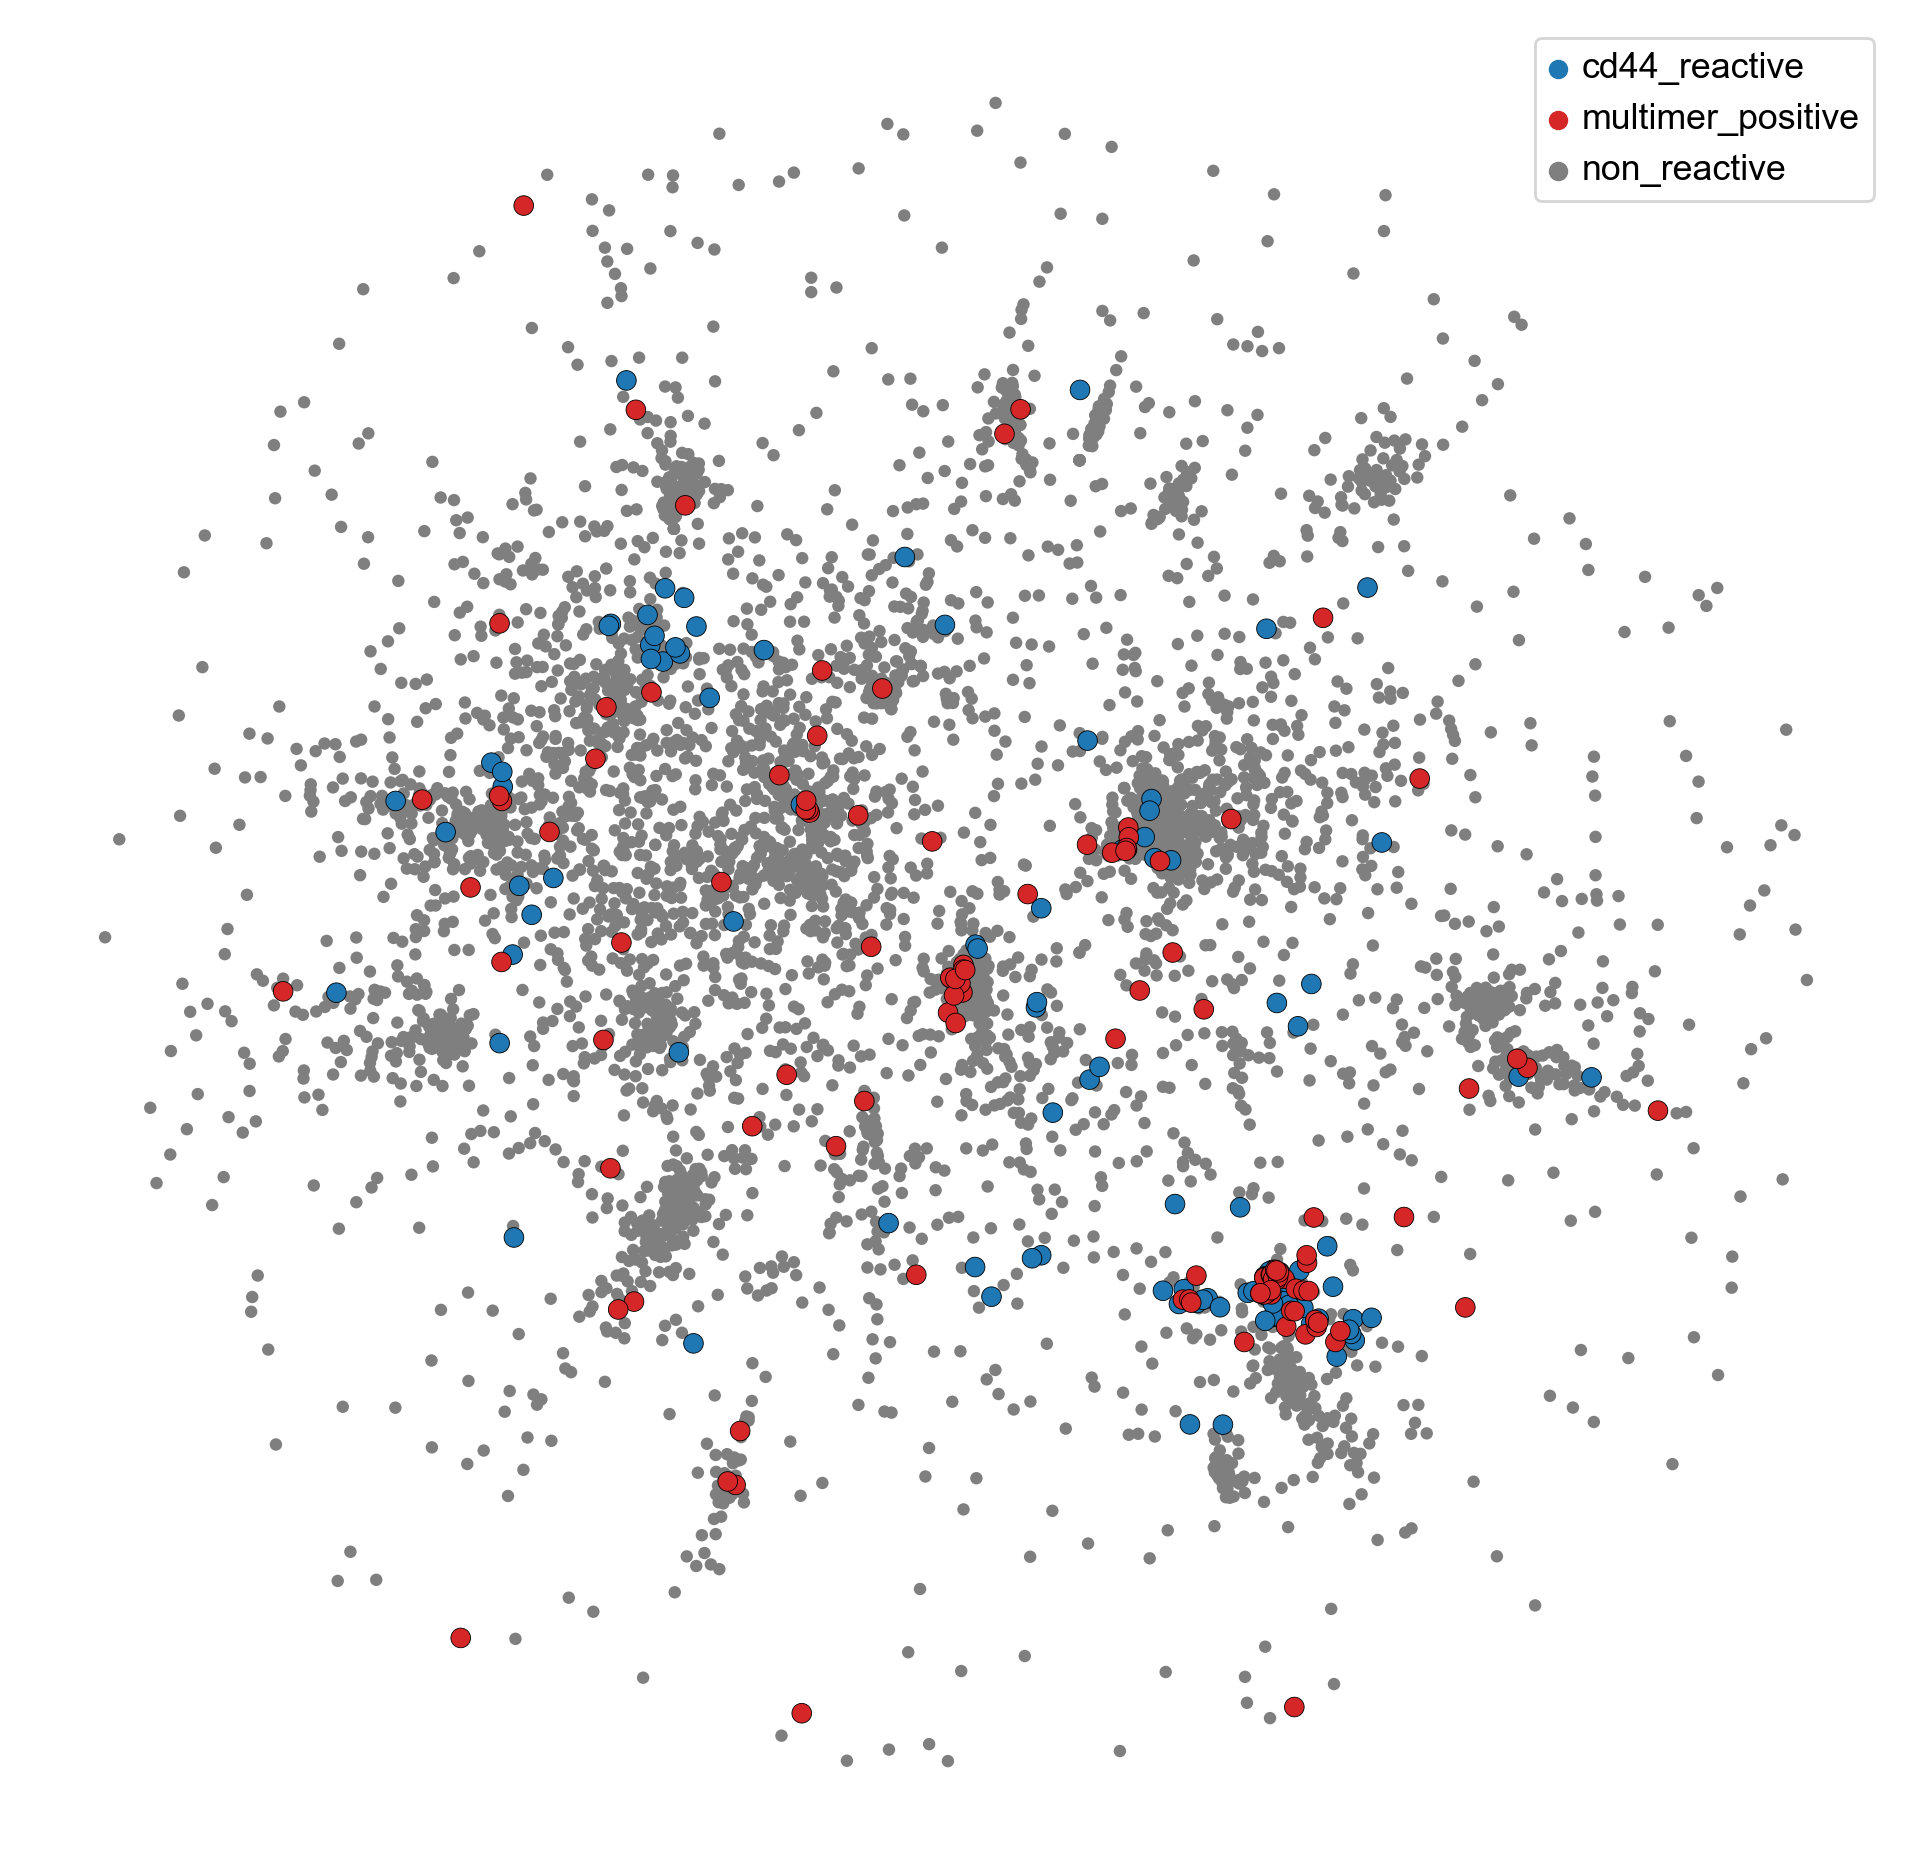

In [540]:
fig, ax = plt.subplots(ncols=1, figsize=(12,12))
sns.scatterplot(data=clone_df[clone_df.epitope_isolation=='non_reactive'], x='xpos', y='ypos', hue='epitope_isolation', hue_order=['cd44_reactive','multimer_positive','non_reactive',],
                palette = ['tab:blue','tab:red', 'tab:gray', ], ax=ax,
                edgecolor='black', linewidth=0, s=20, legend=True)
ax.legend(loc='upper right')
sns.scatterplot(data=clone_df[clone_df.epitope_isolation=='cd44_reactive'], x='xpos', y='ypos', hue='epitope_isolation', hue_order=['cd44_reactive','multimer_positive','non_reactive',],
                palette = ['tab:blue','tab:red', 'tab:gray', ], ax=ax,
                edgecolor='black', linewidth=0.3, s=50, legend=False)

sns.scatterplot(data=clone_df[clone_df.epitope_isolation=='multimer_positive'], x='xpos', y='ypos', hue='epitope_isolation', hue_order=['cd44_reactive','multimer_positive','non_reactive',],
                palette = ['tab:blue','tab:red', 'tab:gray', ], ax=ax,
                edgecolor='black', linewidth=0.3, s=50, legend=False)

ax.axis("off")

### Plot raw distances

In [790]:
tr_multimer.pw_alpha_beta = tr_multimer.pw_beta + tr_multimer.pw_alpha
tr_cd44.pw_alpha_beta = tr_cd44.pw_beta + tr_cd44.pw_alpha

In [791]:
multimer_array = tr_multimer.pw_alpha_beta[tr_multimer.pw_alpha_beta != 0].tolist()
cd44_array = tr_cd44.pw_alpha_beta[tr_cd44.pw_alpha_beta != 0].tolist()

In [792]:
data = {'distance': multimer_array}
df = pd.DataFrame(data)
df['isolation']='multimer'

In [793]:
data = {'distance': cd44_array}
df_1 = pd.DataFrame(data)
df_1['isolation']='cd44'
df = df.append(df_1)

In [794]:
df.to_csv('./analysis_output/tcrdist/selected/raw_distances.csv')

In [795]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

In [796]:
cv_cd44 = "{:.1f}".format(cv(df[df.isolation=='cd44'].distance.tolist()))
mean_cd44 = "{:.1f}".format(df[df.isolation=='cd44'].distance.mean())
cv_multimer = "{:.1f}".format(cv(df[df.isolation=='multimer'].distance.tolist()))
mean_multimer = "{:.1f}".format(df[df.isolation=='multimer'].distance.mean())

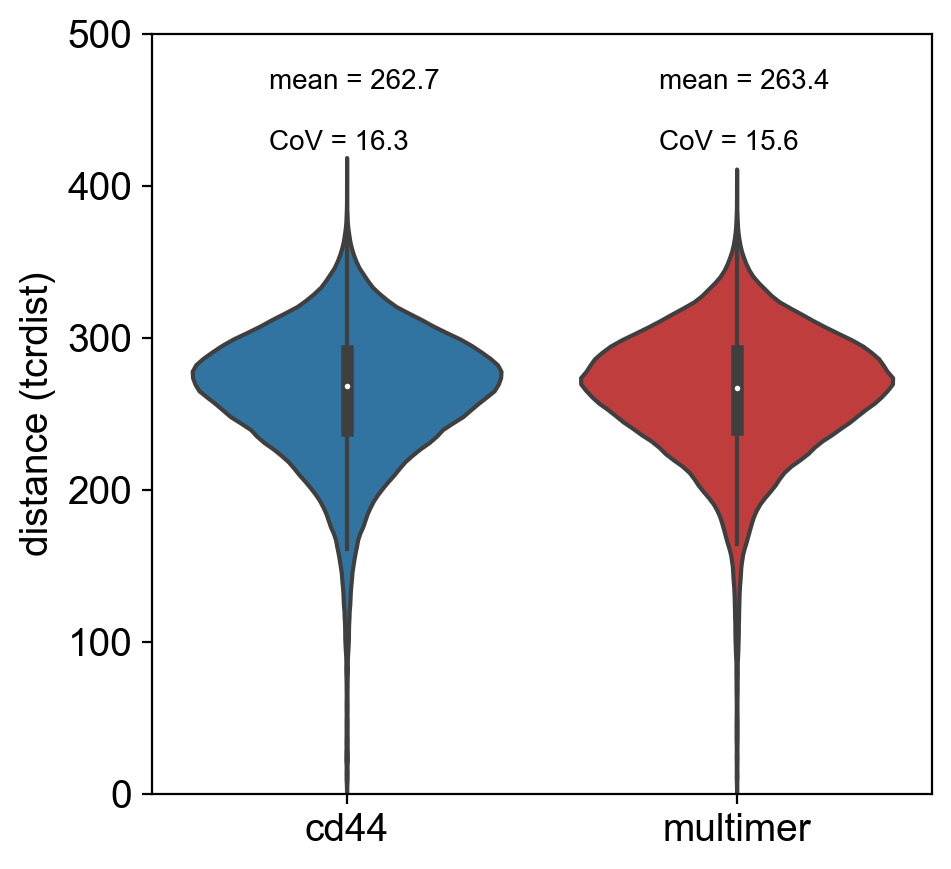

In [797]:
fig,ax = plt.subplots(figsize=(5,5))
sns.violinplot(data=df, x='isolation',y='distance', inner='box', order=['cd44','multimer'], palette=['tab:blue','tab:red'], ax=ax)
ax.axis([-0.5, 1.5, 0, 500])
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('distance (tcrdist)')

ax.text(-0.2, 460, 'mean = ' + str(mean_cd44),
        verticalalignment='bottom', horizontalalignment='left',
        #transform=ax.transAxes,
        color='black', fontsize=10)
ax.text(-0.2, 420, 'CoV = ' + str(cv_cd44),
        verticalalignment='bottom', horizontalalignment='left',
        #transform=ax.transAxes,
        color='black', fontsize=10)


ax.text(0.8, 460, 'mean = ' + str(mean_multimer),
        verticalalignment='bottom', horizontalalignment='left',
        #transform=ax.transAxes,
        color='black', fontsize=10)
ax.text(0.8, 420, 'CoV = ' + str(cv_multimer),
        verticalalignment='bottom', horizontalalignment='left',
        #transform=ax.transAxes,
        color='black', fontsize=10)
ax.grid(False)


plt.savefig('./analysis_output/tcr_clusters/selected/raw_dist.eps')

### Clonal overlap between methods

Annotate clonotypes based on amino acid identity

In [541]:
ir.pp.ir_dist(adata, inplace=True, metric='identity', sequence='aa', key_added='dist_aa_identity', cutoff=0)

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.


In [542]:
ir.tl.define_clonotype_clusters(adata, metric="identity", receptor_arms = 'all', sequence="aa", dual_ir = 'primary_only',
                                key_added='clone_id_aa', 
                                distance_key='dist_aa_identity' , same_v_gene=False,n_jobs=15)

Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:02)
Computing clonotype x clonotype distances.
NB: Computation happens in chunks. The progressbar only advances when a chunk has finished. 


  0%|          | 0/36388 [00:00<?, ?it/s]

--> Done computing clonotype x clonotype distances.  (0:00:54)
Stored clonal assignments in `adata.obs["clone_id_aa"]`.


<AxesSubplot: >

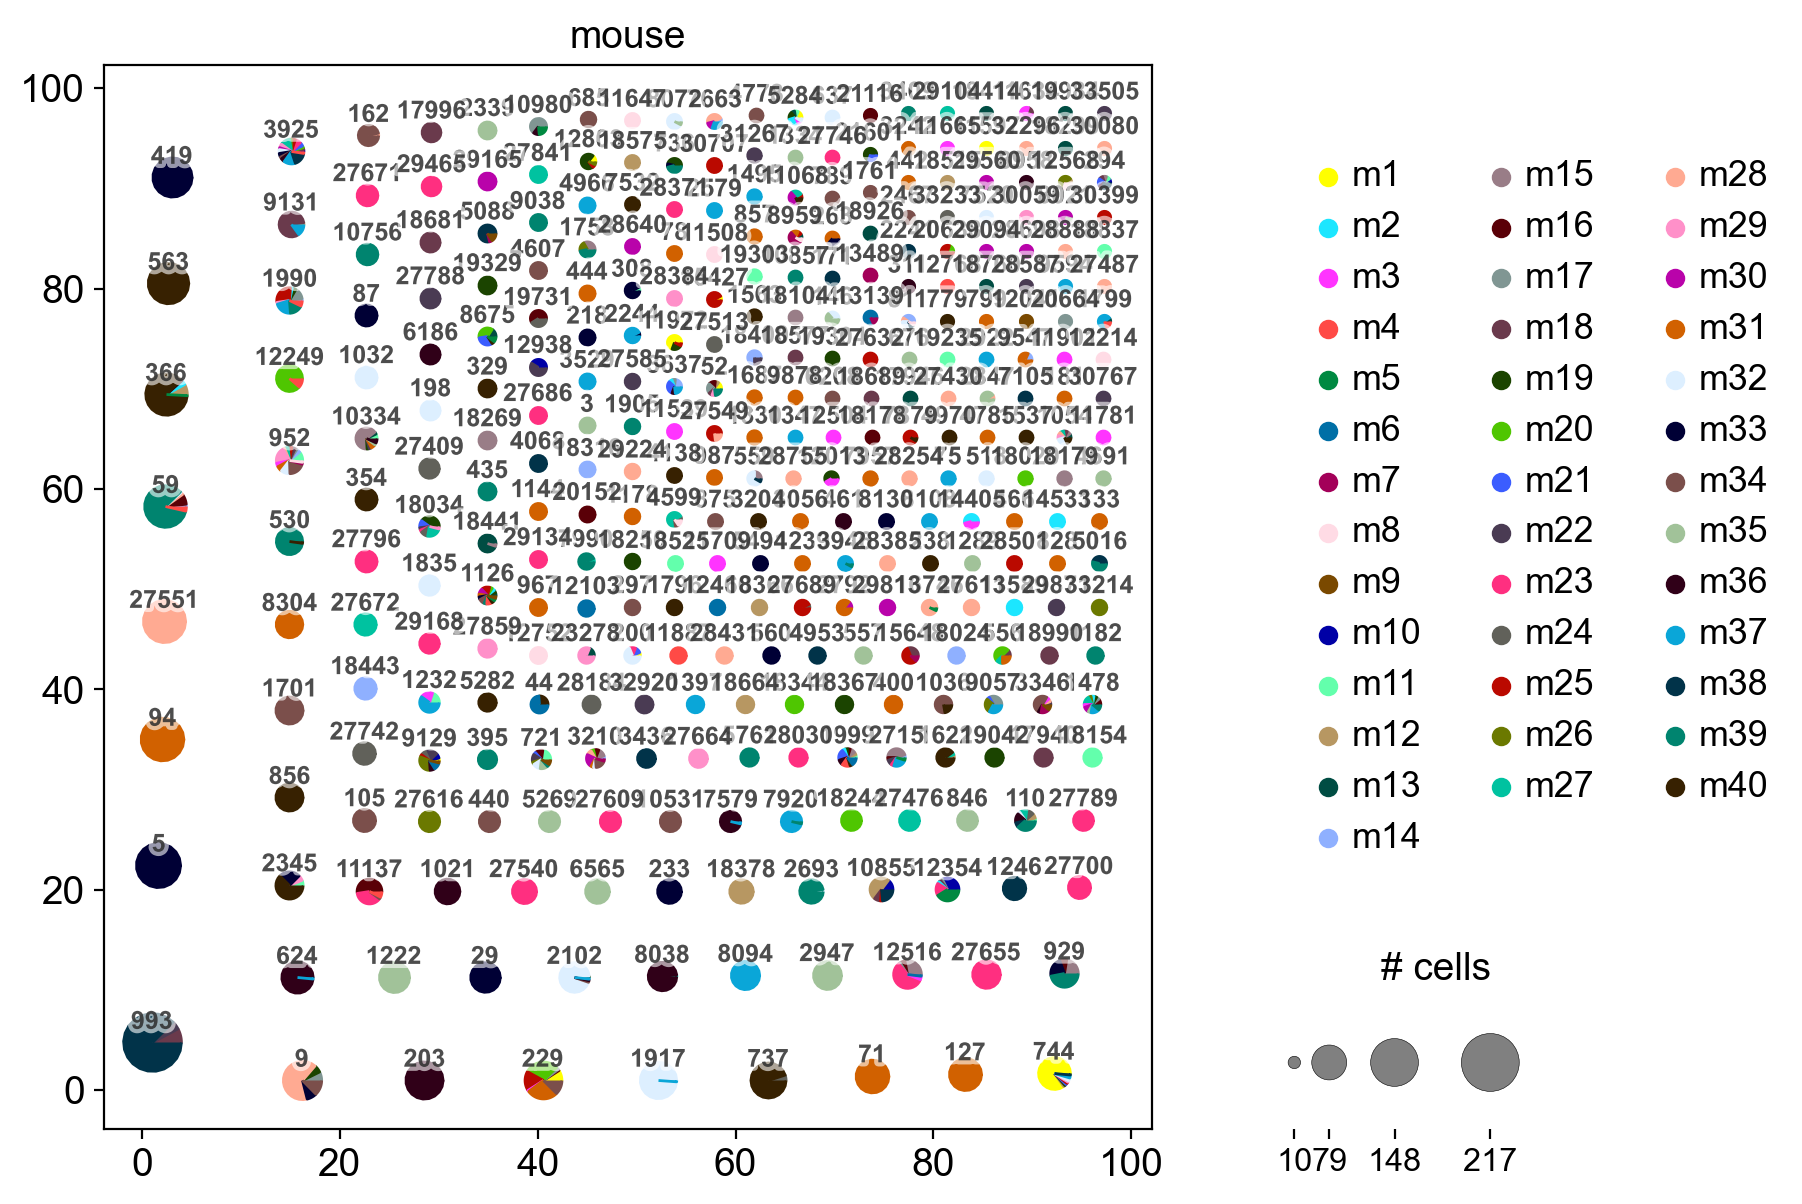

In [545]:
ir.tl.clonotype_network(adata, min_cells=10, clonotype_key='clone_id_aa')
ir.pl.clonotype_network(
    adata, color="mouse", label_fontsize=9, panel_size=(7, 7), base_size=2
)

In [547]:
exp_list = adata.obs.experiment.unique().tolist()
exp_group_list = adata.obs.exp_group.unique().tolist()
mouse_list = adata.obs.mouse.unique().tolist()

In [548]:
adata.obs['clonotype_size_mouse_aa_only']=adata.obs.clone_id_aa_size

In [549]:
all_clones = adata.obs.clone_id_aa[adata.obs.clone_id_aa_size>1].unique().tolist()

In [550]:
for i, mouse in enumerate(mouse_list):
    print(str(i+1), end="\r", flush=True)
    donor_list = adata.obs[adata.obs.mouse==mouse].clone_id_aa.unique().tolist()
    clone_list = [x for x in donor_list if x in all_clones]
    for clonotype in clone_list:
        adata.obs.clonotype_size_mouse_aa_only[np.logical_and(adata.obs.mouse==mouse,adata.obs.clone_id_aa==clonotype)] = adata.obs.clone_id_aa[np.logical_and(adata.obs.mouse==mouse,adata.obs.clone_id_aa==clonotype)].value_counts()[0]
       
    

Clonal overlap between experimental conditions

In [659]:
cd44_clones_aa = adata.obs.clone_id_aa[np.logical_and(
    np.logical_and(adata.obs.siinfekl=='siinfekl_specific',adata.obs.multimer=='not_stained'),
    adata.obs.clone_id_aa_size>1)].unique().tolist()
multimer_clones_aa = adata.obs.clone_id_aa[np.logical_and(
    adata.obs.multimer=='mult_pos', adata.obs.clone_id_aa_size>1)].unique().tolist()

In [660]:
overlap_aa = [clone for clone in cd44_clones_aa if clone in multimer_clones_aa]

In [661]:
print(len(cd44_clones_aa))
print(len(multimer_clones_aa))

653
503


In [662]:
len(overlap_aa)

35

In [678]:
cd44_clones_nt = adata.obs.clone_id[np.logical_and(
    np.logical_and(adata.obs.siinfekl=='siinfekl_specific',adata.obs.multimer=='not_stained'),
    adata.obs.clone_id_size>1)].unique().tolist()
multimer_clones_nt = adata.obs.clone_id[np.logical_and(
    adata.obs.multimer=='mult_pos', adata.obs.clone_id_size>1)].unique().tolist()

In [679]:
print(len(cd44_clones_nt))
print(len(multimer_clones_nt))

659
505


In [680]:
overlap_nt = [clone for clone in cd44_clones_nt if clone in multimer_clones_nt]

In [681]:
len(overlap_nt)

0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


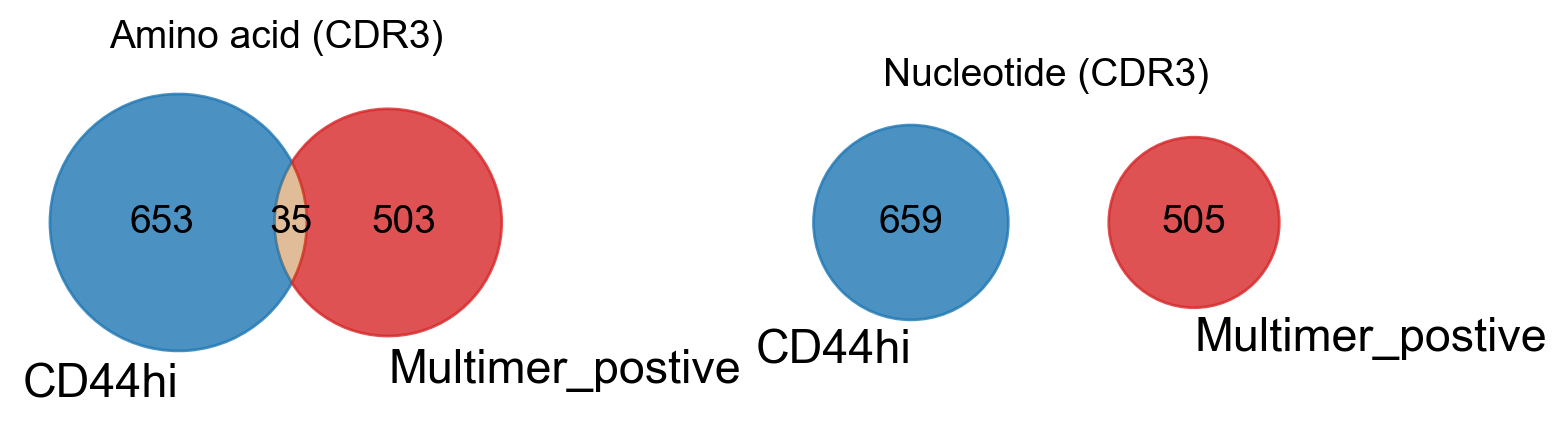

In [798]:
from matplotlib_venn import venn2

fig, ax = plt.subplots(figsize=(8,3), ncols=2)
# Use the venn2 function
v = venn2(subsets = (len(cd44_clones_aa), len(multimer_clones_aa), len(overlap_aa)), 
          set_labels = ('CD44hi', 'Multimer_postive'),ax=ax[0])
v.get_patch_by_id('100').set_color('tab:blue')
v.get_patch_by_id('010').set_color('tab:red')
v.get_patch_by_id('100').set_alpha(0.8)
v.get_patch_by_id('010').set_alpha(0.8)
ax[0].set_title("Amino acid (CDR3)")


v2 = venn2(subsets = (len(cd44_clones_nt), len(multimer_clones_nt), len(overlap_nt)), 
          set_labels = ('CD44hi', 'Multimer_postive'), ax=ax[1])
v2.get_patch_by_id('100').set_color('tab:blue')
v2.get_patch_by_id('010').set_color('tab:red')
v2.get_patch_by_id('100').set_alpha(0.8)
v2.get_patch_by_id('010').set_alpha(0.8)
ax[1].set_title("Nucleotide (CDR3)")

#plt.show()

fig.tight_layout()

plt.savefig('./analysis_output/tcr_clusters/selected/experimental_overlap.eps')



Sharedness between mice

In [652]:
clones = cd44_clones_aa + multimer_clones_aa
siinfekl_clones_aa = list(set(clones))

clones = cd44_clones_nt + multimer_clones_nt
siinfekl_clones_nt = list(set(clones))

Amino acid

In [689]:
all_clones_exp_aa = adata.obs.clone_id_aa[adata.obs.clone_id_aa_size>1].unique().tolist()

In [690]:
adata.obs['shared_mouse_aa'] = 1
for clone in all_clones_exp_aa:
    shared = len(adata.obs[adata.obs.clone_id_aa==clone].mouse.unique())
    adata.obs.shared_mouse_aa[adata.obs.clone_id_aa==clone] = shared
    

Nucleotide

In [691]:
all_clones_exp_nt = adata.obs.clone_id[adata.obs.clone_id_size>1].unique().tolist()

In [692]:
adata.obs['shared_mouse_nt'] = 1
for clone in all_clones_exp_nt:
    shared = len(adata.obs[adata.obs.clone_id==clone].mouse.unique())
    adata.obs.shared_mouse_nt[adata.obs.clone_id==clone] = shared
    

Plot sharedness

In [696]:
siinfekl_clones_aa_1 = adata.obs.clone_id_aa[np.logical_and(
    adata.obs.clone_id_aa.isin(siinfekl_clones_aa),adata.obs.shared_mouse_aa==1)].unique().tolist()
siinfekl_clones_aa_shared = adata.obs.clone_id_aa[np.logical_and(
    adata.obs.clone_id_aa.isin(siinfekl_clones_aa),adata.obs.shared_mouse_aa>1)].unique().tolist()

In [698]:
siinfekl_clones_nt_1 = adata.obs.clone_id_aa[np.logical_and(
    adata.obs.clone_id.isin(siinfekl_clones_nt),adata.obs.shared_mouse_nt==1)].unique().tolist()
siinfekl_clones_aa_shared = adata.obs.clone_id_aa[np.logical_and(
    adata.obs.clone_id.isin(siinfekl_clones_nt),adata.obs.shared_mouse_nt>1)].unique().tolist()

In [708]:
len(adata.obs.clone_id_aa[np.logical_and(
    adata.obs.clone_id_aa.isin(siinfekl_clones_aa),adata.obs.shared_mouse_aa==1)].unique())

947

In [709]:
init = len(adata.obs.clone_id_aa[np.logical_and(
    adata.obs.clone_id_aa.isin(siinfekl_clones_aa),adata.obs.shared_mouse_aa==1)].unique())
siinfekl_clones_aa_sharedness = []
siinfekl_clones_aa_sharedness.append(init)

for i in list(range(1,11)):
    sharedness = len(adata.obs.clone_id_aa[np.logical_and(
        adata.obs.clone_id_aa.isin(siinfekl_clones_aa),adata.obs.shared_mouse_aa>i)].unique())
    siinfekl_clones_aa_sharedness.append(sharedness)

In [712]:
init = len(adata.obs.clone_id[np.logical_and(
    adata.obs.clone_id.isin(siinfekl_clones_nt),adata.obs.shared_mouse_nt==1)].unique())
siinfekl_clones_nt_sharedness = []
siinfekl_clones_nt_sharedness.append(init)

for i in list(range(1,11)):
    sharedness = len(adata.obs.clone_id[np.logical_and(
        adata.obs.clone_id.isin(siinfekl_clones_nt),adata.obs.shared_mouse_nt>i)].unique())
    siinfekl_clones_nt_sharedness.append(sharedness)

In [714]:
labeling = ['unique']
for i in list(range(1,11)):
    labeling.append('>' + str(i))

In [799]:
data = {'mouse_repertoire': labeling, 'amino_acid': siinfekl_clones_aa_sharedness, 'nucleotide': siinfekl_clones_nt_sharedness}
df = pd.DataFrame(data)

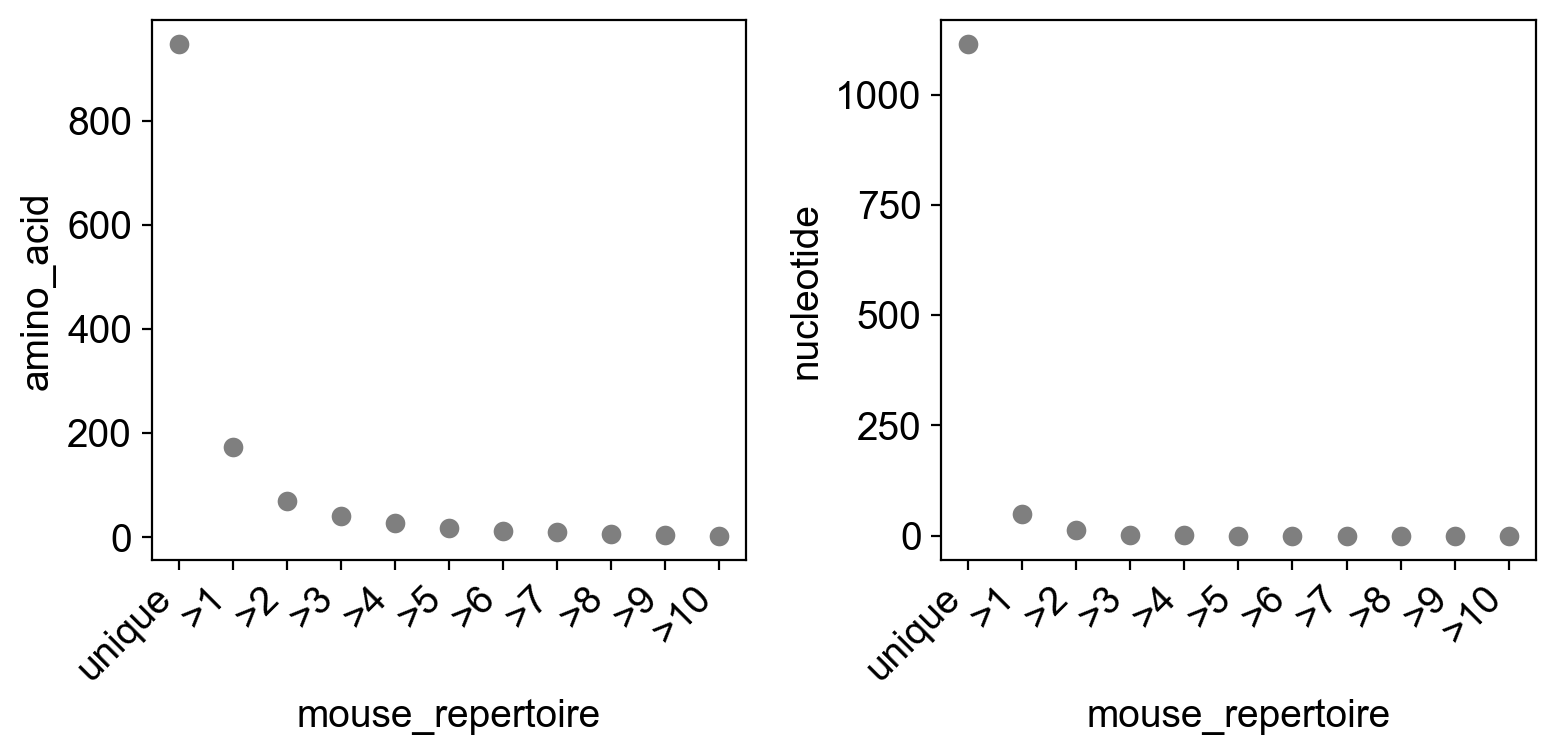

In [800]:
fig, ax = plt.subplots(figsize=(8,4), ncols=2)
sns.scatterplot(data=df, x='mouse_repertoire', y='amino_acid', ax=ax[0], 
                color=['tab:gray'], edgecolor=['tab:red'], linewidth = 0, s=50)
ax[0].set_xticklabels(labeling, rotation=45, ha='right')
ax[0].grid(False)

sns.scatterplot(data=df, x='mouse_repertoire', y='nucleotide', ax=ax[1],
                color=['tab:gray'], edgecolor=['tab:red'], linewidth = 0, s=50)
ax[1].set_xticklabels(labeling, rotation=45, ha='right')
ax[1].grid(False)
fig.tight_layout()

plt.savefig('./analysis_output/tcr_clusters/selected/clonal_sharedness.eps')